In [2]:
from folktables import ACSDataSource
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import folktables
import numpy as np
from bestLS_hindsight import *
from OnlineRidgeRiver import *
from lean_adahedge import *
import matplotlib.pyplot as plt
from bestLS_hindsight_together import *
from oridge_alwaysactive_implementable import *

from build_all_models import *

from folktables.load_acs import state_list

In [3]:
def plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh):
  Anhbetter_count = 0
  N = len(Anh.cuml_regret_curve)
  for gnum in range(N):  
    oridge_regret_g = cumreg_groupwise_oridge[gnum]
    Tg = len(oridge_regret_g) # number of rounds this group is active
    Anh_end = Anh.cuml_regret_curve[gnum][-1] # last time steps cumulative regret
    oridge_end = oridge_regret_g[-1]
    if Anh_end <= oridge_end:
      Anhst = "Yes"
      Anhbetter_count += 1
    else:
      Anhst = "No"
    print(f'''Group number {gnum}, Tg is {Tg} \n
    oridge end regret {oridge_end}, Anh end regret {Anh_end}, \n
    Anh better {Anhst} ''')
    print(f'''Oridge regret - Anh regret implementables {oridge_end - Anh_end}''')
    # if Anhst == "Yes":
    #   print(f''' Delta / larger % {100 * (oridge_end - Anh_end) / abs(oridge_end)} ''')
    # else:
    #   print(f''' Delta / larger % {100 * (Anh_end - oridge_end) / abs(Anh_end)} ''')
    rel_diff = 2 * abs(oridge_end - Anh_end) / (abs(oridge_end) + abs(Anh_end))
    print(f'''Relative difference percent {100 * rel_diff}''')  # https://en.wikipedia.org/wiki/Relative_change_and_difference
    # print(f'''Anh is {Anh_end / oridge_end} fraction of Oridge regret''')
    # print(f'''Anh is {100 * (1 - (Anh_end / oridge_end))} % smaller than Oridge regret''')
    time_steps = np.arange(1, Tg+1)
    plt.plot(time_steps, cumreg_groupwise_oridge[gnum],'-b', label="Online Ridge (OR)")
    plt.plot(time_steps, Anh.cuml_regret_curve[gnum], '-r', label="Anh with OR meta experts")
    plt.xlabel("Time slots")
    plt.ylabel("Regret")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  print(f'Anh better for {Anhbetter_count} out of {N} groups') # caught a bug here!

In [4]:
# Ira Globus code schema, and choosing only Significant features
ACSIncome = folktables.BasicProblem(
    features = ['OCCP', 'WKHP', 'AGEP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX',
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'],
    target='PINCP',
    # target_transform=lambda x: x > 50000,    
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

cat_cols_sig = ['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX', 
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'] # significant features from the earlier analysis

print('Selected states: ', state_list)
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
acs_data = data_source.get_data(state_list, download=True)

X, y, gr = ACSIncome.df_to_pandas(acs_data)
dataset = pd.concat([X, y], axis=1)

for catg in cat_cols_sig:
    dataset[catg] = dataset[catg].astype(int)

Selected states:  ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']


In [5]:
data_incomeless200k = dataset[dataset['PINCP'] <= 2e5]
data_fil = data_incomeless200k
# top_200OCCP = dataset['OCCP'].value_counts()[:250].index.tolist() # top 200 occupation codes in the original dataframe
# data_fil = data_incomeless200k[data_incomeless200k['OCCP'].isin(top_200OCCP)]
print(len(data_fil) / len(dataset)) #top200 occp codes and <= 200k is 83 % of original dataset

0.9625934030071766


# shuffled but undropped
seed = 21, default

In [4]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'allstates2021_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_temp = {}
di_temp['bls'] = 1
di_temp['Anh'] = 2
di_temp['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_temp, to_shuffle=True, to_drop_groups = False)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [14:04<00:00, 1857.08it/s]


In [5]:
di_temp

{'bls': <bestLS_hindsight_together.BestLS_Hindsight_Together at 0x35434bad0>,
 'Anh': <lean_adahedge.Adanormal_sleepingexps at 0x6477bd910>,
 'oridge_implementable': <oridge_alwaysactive_implementable.OnlineRidgeImplementable_alwaysactive at 0x37c9eca10>,
 'A_t': array([[1, 0, 1, ..., 0, 0, 1],
        [0, 1, 1, ..., 0, 0, 1],
        [1, 0, 1, ..., 0, 0, 1],
        ...,
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 1, ..., 0, 0, 1],
        [1, 0, 1, ..., 0, 0, 1]])}

Group number 0, Tg is 805503 

    oridge end regret 10636.786582858625, Anh end regret 9733.692620986698, 

    Anh better Yes 
Oridge regret - Anh regret implementables 903.0939618719276
Relative difference percent 8.866693344174752


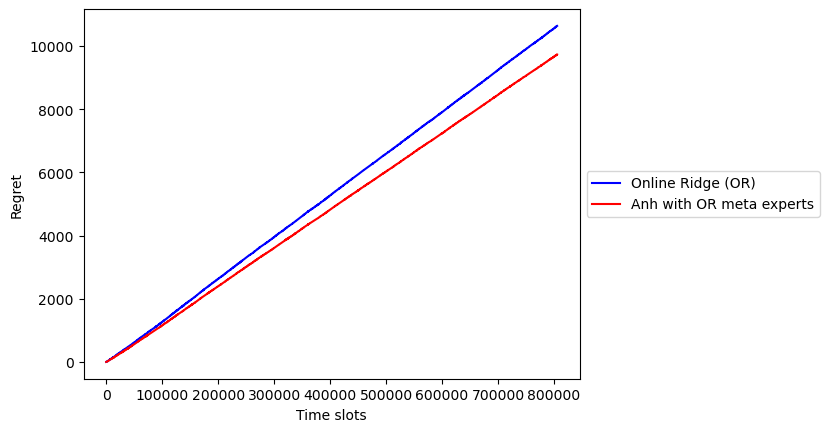

Group number 1, Tg is 763685 

    oridge end regret 8643.141489419555, Anh end regret 8419.842147319374, 

    Anh better Yes 
Oridge regret - Anh regret implementables 223.2993421001811
Relative difference percent 2.6173539968635637


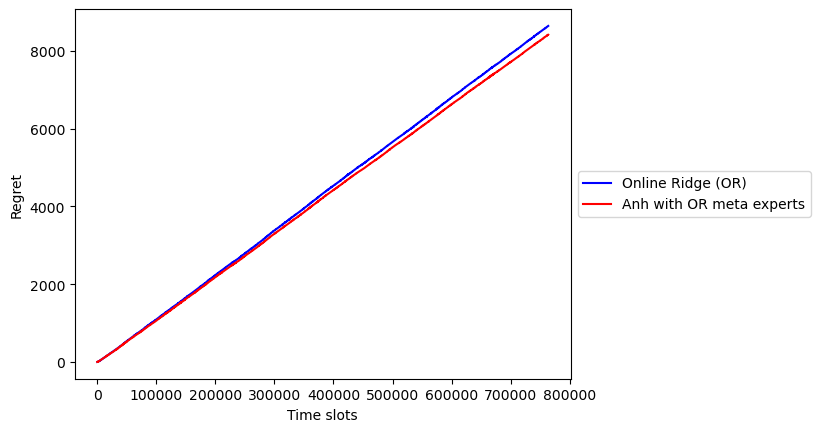

Group number 2, Tg is 1045807 

    oridge end regret 13260.758232793381, Anh end regret 12719.826169744225, 

    Anh better Yes 
Oridge regret - Anh regret implementables 540.9320630491566
Relative difference percent 4.164125445895066


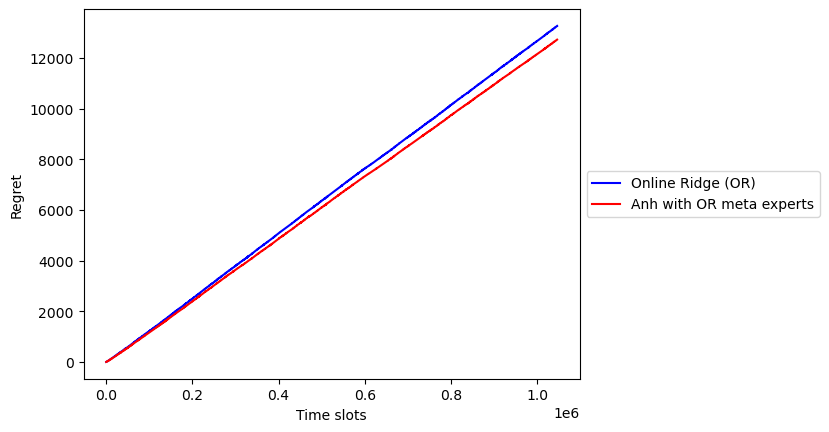

Group number 3, Tg is 136227 

    oridge end regret 1134.271059019918, Anh end regret 1064.3980636457468, 

    Anh better Yes 
Oridge regret - Anh regret implementables 69.8729953741713
Relative difference percent 6.3559354751348245


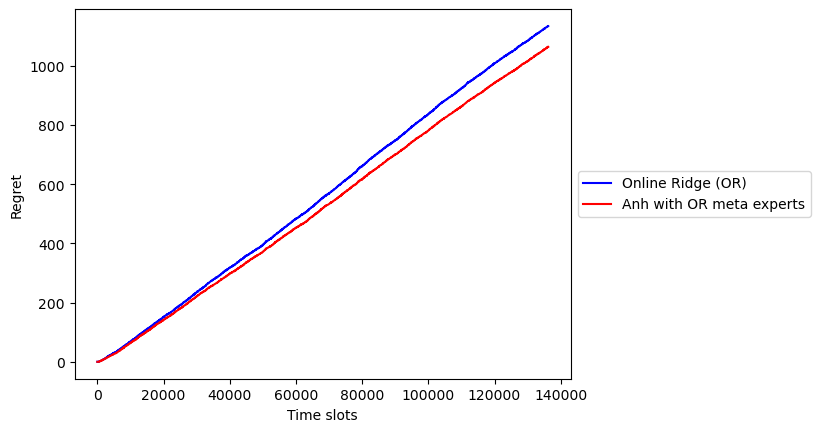

Group number 4, Tg is 14455 

    oridge end regret 86.04737673509885, Anh end regret 71.2692387613622, 

    Anh better Yes 
Oridge regret - Anh regret implementables 14.778137973736648
Relative difference percent 18.787764950446817


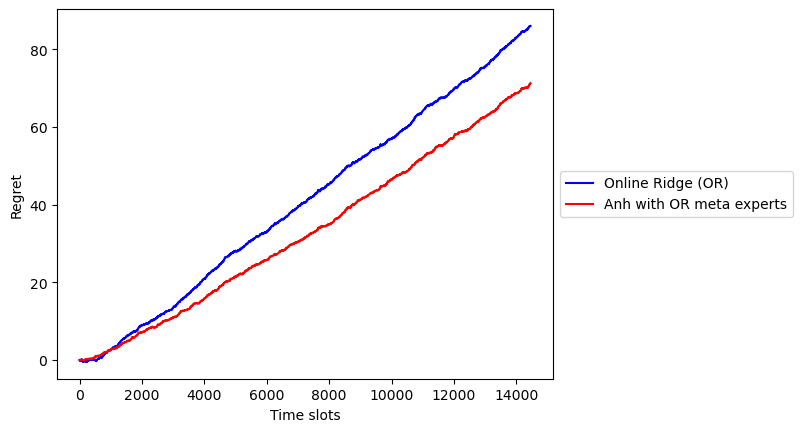

Group number 5, Tg is 726 

    oridge end regret 1.4031296652651193, Anh end regret 1.1912910616522794, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.2118386036128399
Relative difference percent 16.330320014405622


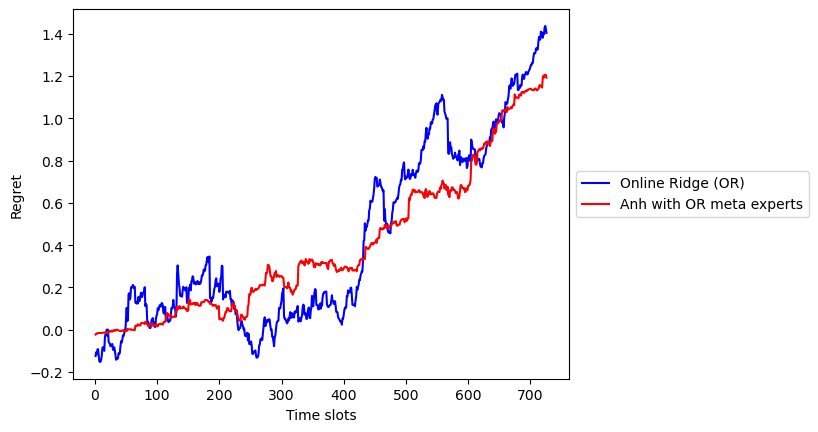

Group number 6, Tg is 2316 

    oridge end regret 13.126594366225724, Anh end regret 9.663408677472042, 

    Anh better Yes 
Oridge regret - Anh regret implementables 3.4631856887536827
Relative difference percent 30.392147663283218


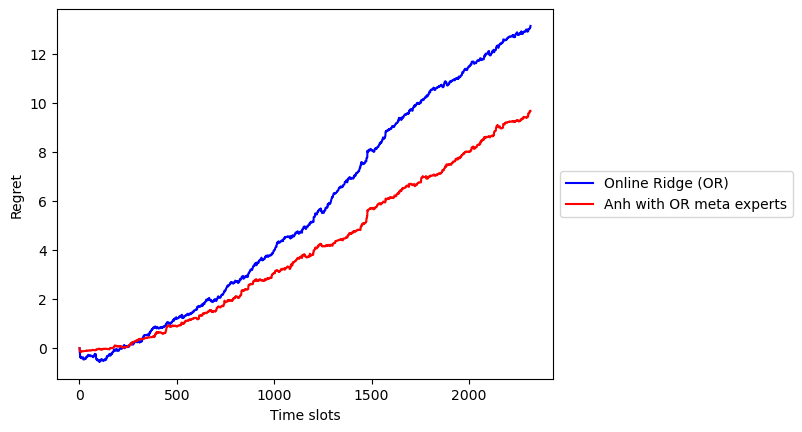

Group number 7, Tg is 100852 

    oridge end regret 2027.3270624123056, Anh end regret 1682.0914247720625, 

    Anh better Yes 
Oridge regret - Anh regret implementables 345.2356376402431
Relative difference percent 18.614003183140117


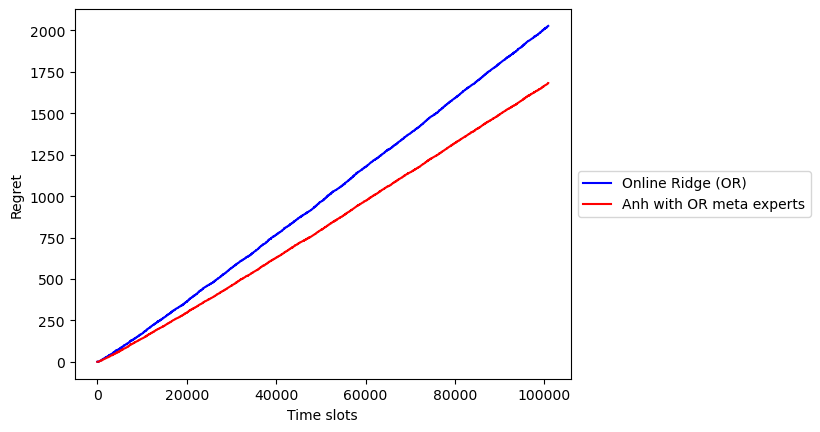

Group number 8, Tg is 2755 

    oridge end regret 10.204610847830722, Anh end regret 11.405812794289034, 

    Anh better No 
Oridge regret - Anh regret implementables -1.201201946458312
Relative difference percent 11.116875507402007


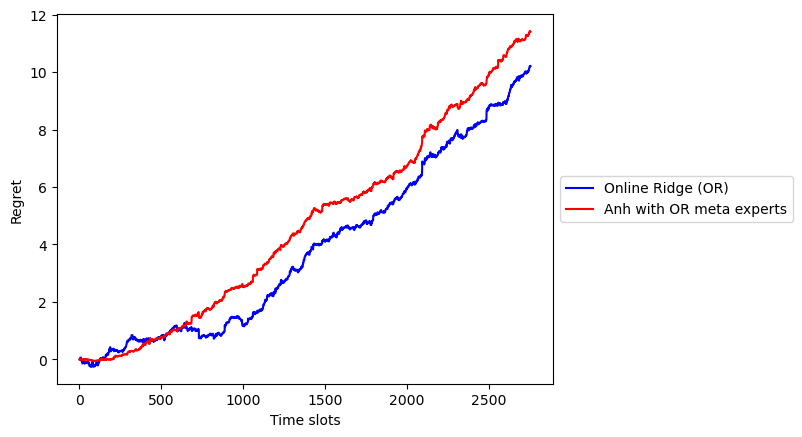

Group number 9, Tg is 97582 

    oridge end regret 724.5682885196945, Anh end regret 600.4649178129191, 

    Anh better Yes 
Oridge regret - Anh regret implementables 124.10337070677542
Relative difference percent 18.732114804920993


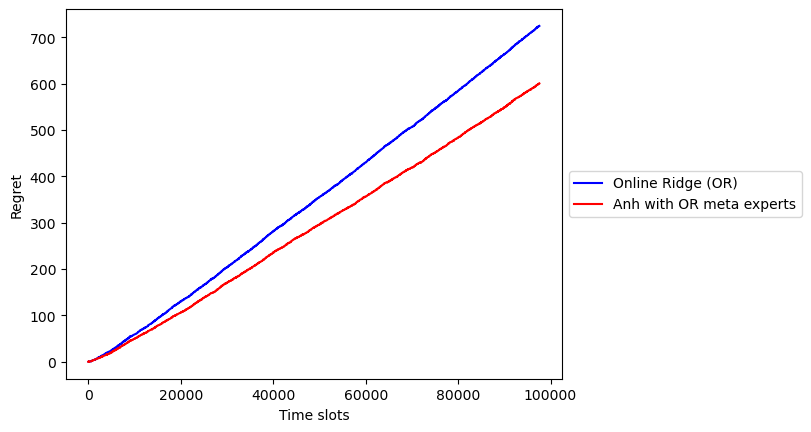

Group number 10, Tg is 168468 

    oridge end regret 1673.0472977946147, Anh end regret 1644.050020912915, 

    Anh better Yes 
Oridge regret - Anh regret implementables 28.99727688169969
Relative difference percent 1.7483524959103796


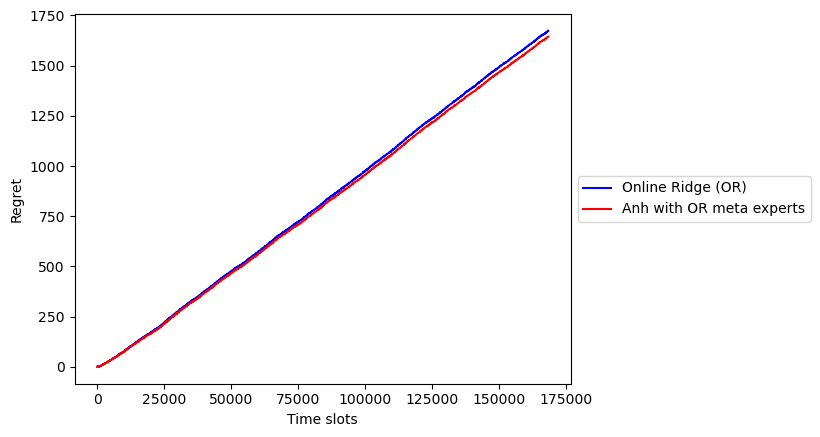

Group number 11, Tg is 1569188 

    oridge end regret 18843.73379641585, Anh end regret 17717.340492446885, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1126.3933039689655
Relative difference percent 6.161707914102997


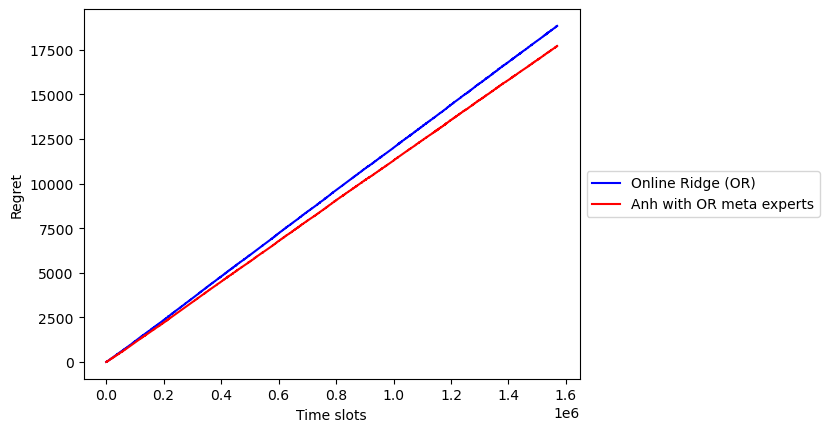

Anh better for 11 out of 12 groups


In [10]:
# shuffled and undropped
plot_ORidgevsAnh_together(di_temp['oridge_implementable'].cumreg_groupwise_oridge, di_temp['Anh'])

# shuffed and dropped

In [13]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'allstates2021_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_sd = {}
di_sd['bls'] = 1
di_sd['Anh'] = 2
di_sd['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_sd, to_shuffle = True, to_drop_groups = True)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [13:57<00:00, 1873.36it/s]


Group number 0, Tg is 805503 

    oridge end regret 11451.367976716494, Anh end regret 9850.555413943199, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1600.8125627732952
Relative difference percent 15.02974668921406


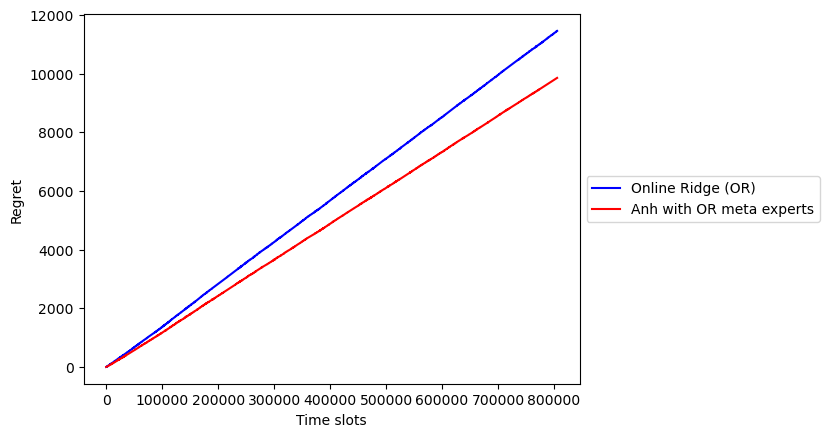

Group number 1, Tg is 763685 

    oridge end regret 9391.372548654615, Anh end regret 8518.576069034227, 

    Anh better Yes 
Oridge regret - Anh regret implementables 872.7964796203887
Relative difference percent 9.746498979437241


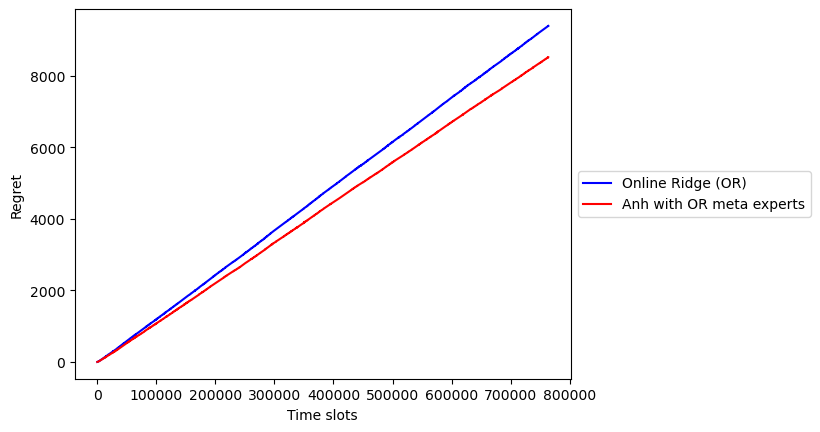

Group number 2, Tg is 1045807 

    oridge end regret 13839.181647669393, Anh end regret 12370.43294859575, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1468.7486990736434
Relative difference percent 11.207709244858101


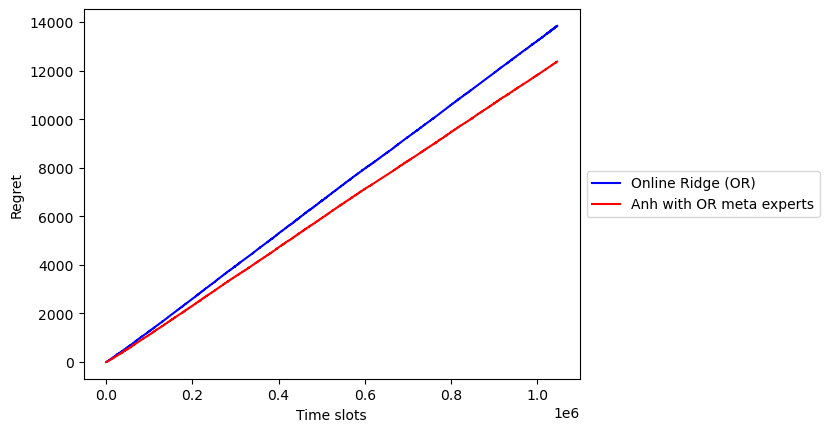

Group number 3, Tg is 136227 

    oridge end regret 1250.5619780319166, Anh end regret 1056.5843703585851, 

    Anh better Yes 
Oridge regret - Anh regret implementables 193.97760767333148
Relative difference percent 16.815370885219572


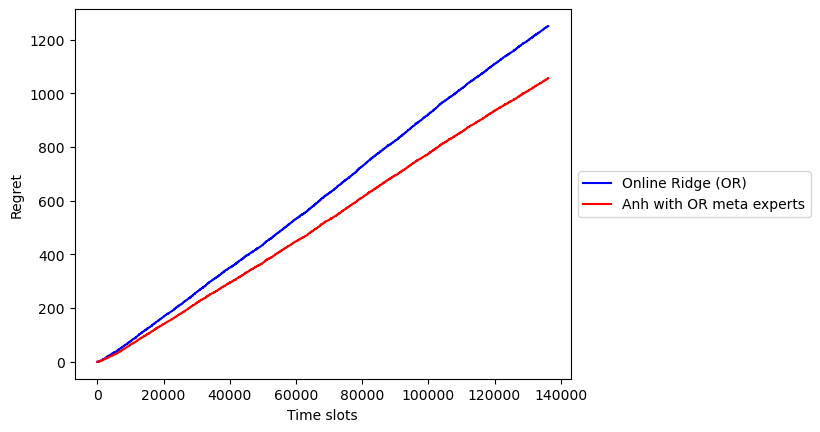

Group number 4, Tg is 14455 

    oridge end regret 98.39669673326364, Anh end regret 72.5900315553746, 

    Anh better Yes 
Oridge regret - Anh regret implementables 25.806665177889045
Relative difference percent 30.18557689965912


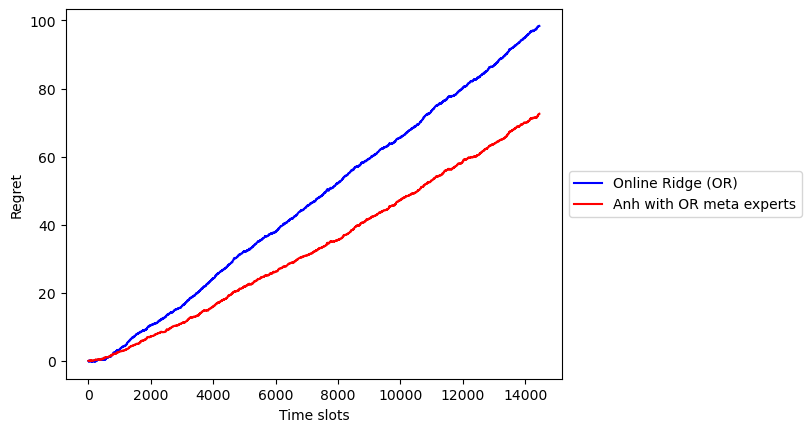

Group number 5, Tg is 726 

    oridge end regret 1.877941338896587, Anh end regret 1.2434446185665173, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.6344967203300698
Relative difference percent 40.654807125854745


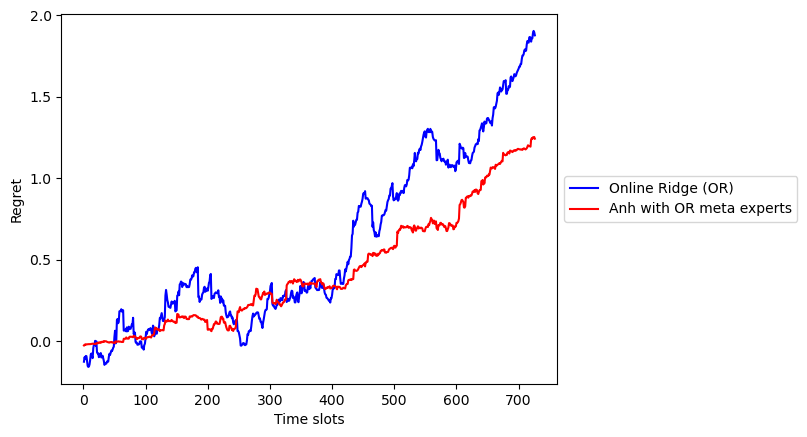

Group number 6, Tg is 2316 

    oridge end regret 14.443537805091786, Anh end regret 9.42567181211998, 

    Anh better Yes 
Oridge regret - Anh regret implementables 5.017865992971807
Relative difference percent 42.044676580773675


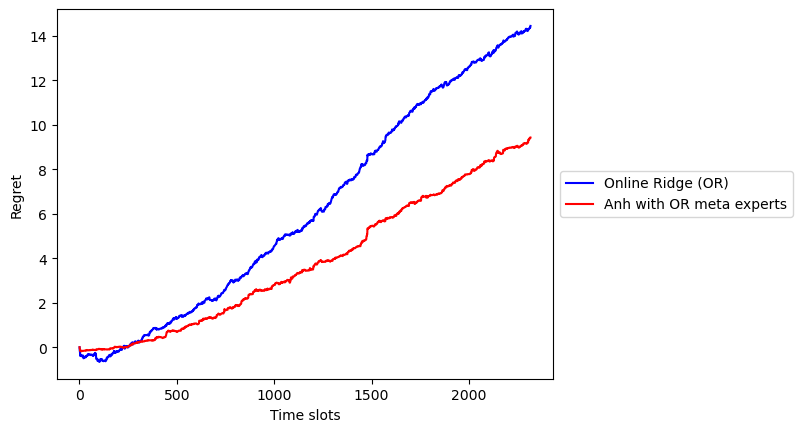

Group number 7, Tg is 100852 

    oridge end regret 2123.35146191658, Anh end regret 1706.7997123169089, 

    Anh better Yes 
Oridge regret - Anh regret implementables 416.551749599671
Relative difference percent 21.751191044464903


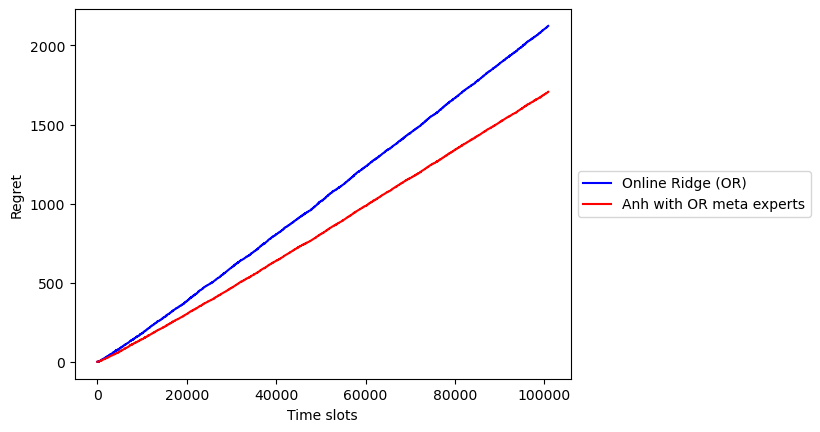

Group number 8, Tg is 2755 

    oridge end regret 11.89295448162595, Anh end regret 11.499525207273976, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.3934292743519734
Relative difference percent 3.3637244070252317


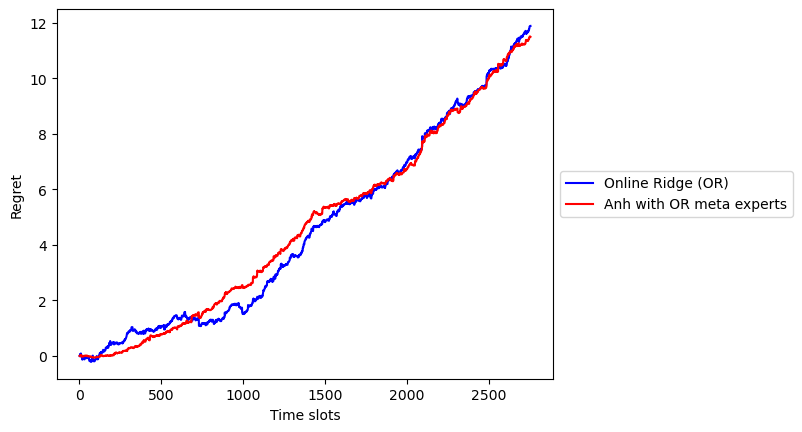

Group number 9, Tg is 97582 

    oridge end regret 834.5010886953371, Anh end regret 617.1167855415936, 

    Anh better Yes 
Oridge regret - Anh regret implementables 217.38430315374353
Relative difference percent 29.9506236471517


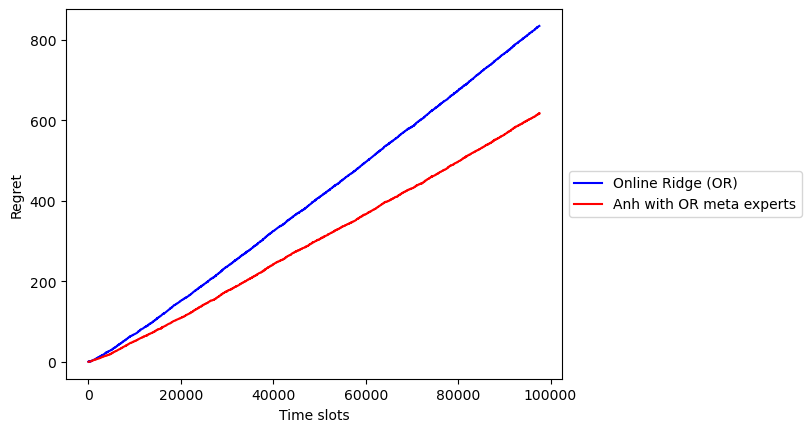

Group number 10, Tg is 168468 

    oridge end regret 1816.3056140434314, Anh end regret 1671.211388315733, 

    Anh better Yes 
Oridge regret - Anh regret implementables 145.09422572769836
Relative difference percent 8.320775246661047


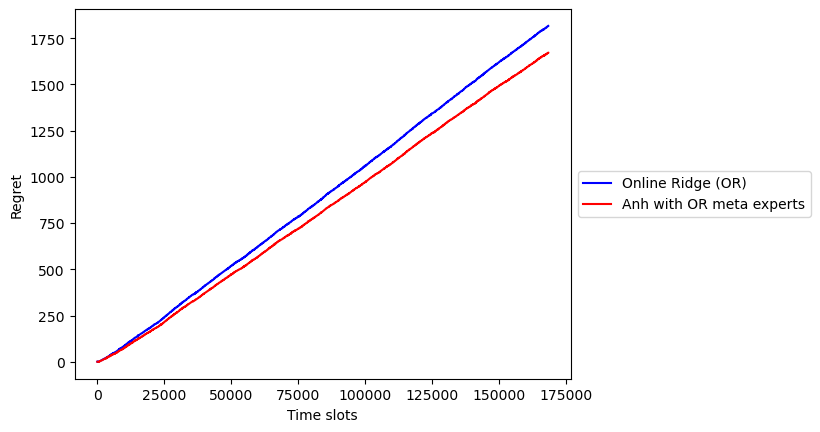

Group number 11, Tg is 1569188 

    oridge end regret 19891.810760845132, Anh end regret 17418.2017184496, 

    Anh better Yes 
Oridge regret - Anh regret implementables 2473.609042395532
Relative difference percent 13.259759930491938


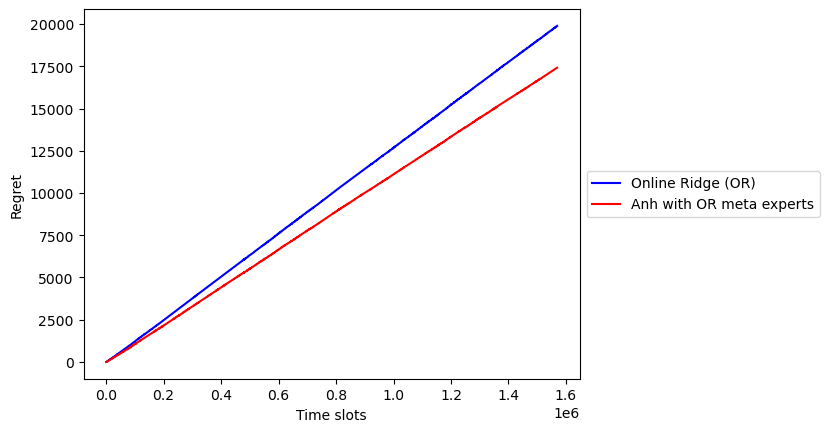

Anh better for 12 out of 12 groups


In [14]:
#shuffled and dropped
plot_ORidgevsAnh_together(di_sd['oridge_implementable'].cumreg_groupwise_oridge, di_sd['Anh'])

# state by state and dropped 

In [7]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'allstates2021_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_temp2 = {}
di_temp2['bls'] = 1
di_temp2['Anh'] = 2
di_temp2['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_temp2, to_shuffle=False, to_drop_groups = True)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [14:00<00:00, 1866.24it/s]


In [8]:
di_temp2

{'bls': <bestLS_hindsight_together.BestLS_Hindsight_Together at 0x6e1324c10>,
 'Anh': <lean_adahedge.Adanormal_sleepingexps at 0x6203bf550>,
 'oridge_implementable': <oridge_alwaysactive_implementable.OnlineRidgeImplementable_alwaysactive at 0x694a2cb10>,
 'A_t': array([[0, 1, 1, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 1],
        [0, 1, 1, ..., 0, 0, 1],
        ...,
        [0, 1, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1],
        [0, 1, 0, ..., 0, 0, 1]])}

Group number 0, Tg is 805503 

    oridge end regret 10770.921875205655, Anh end regret 9329.174098254873, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1441.7477769507823
Relative difference percent 14.345680526644413


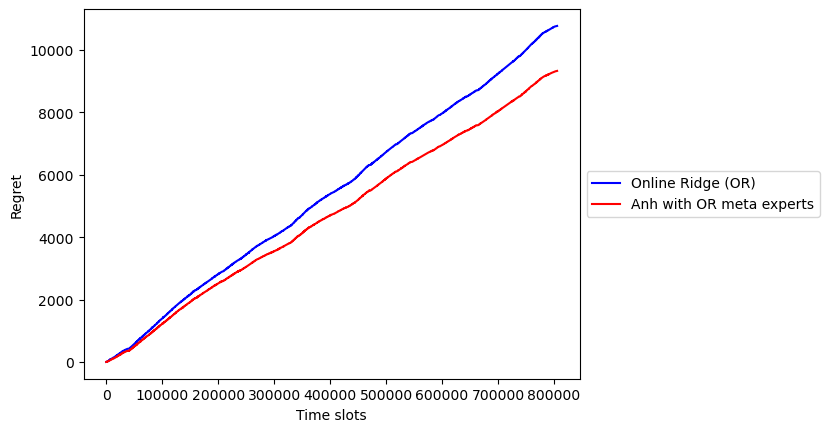

Group number 1, Tg is 763685 

    oridge end regret 8985.724128644457, Anh end regret 8117.497661586129, 

    Anh better Yes 
Oridge regret - Anh regret implementables 868.2264670583281
Relative difference percent 10.152782647702807


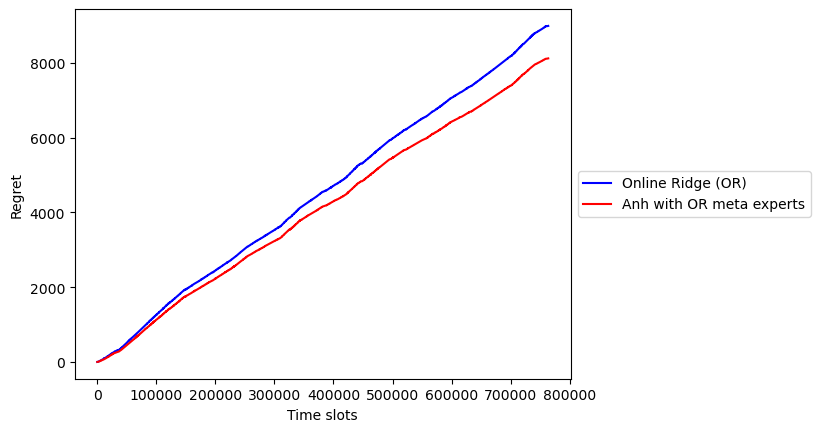

Group number 2, Tg is 1045807 

    oridge end regret 13334.932066637826, Anh end regret 11819.207499803524, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1515.724566834302
Relative difference percent 12.051492064204503


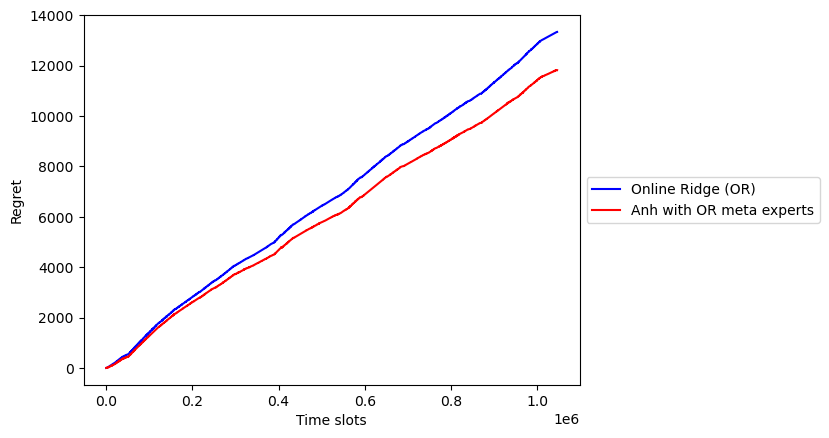

Group number 3, Tg is 136227 

    oridge end regret 1070.6763858050608, Anh end regret 938.2136115975136, 

    Anh better Yes 
Oridge regret - Anh regret implementables 132.46277420754723
Relative difference percent 13.18765829675264


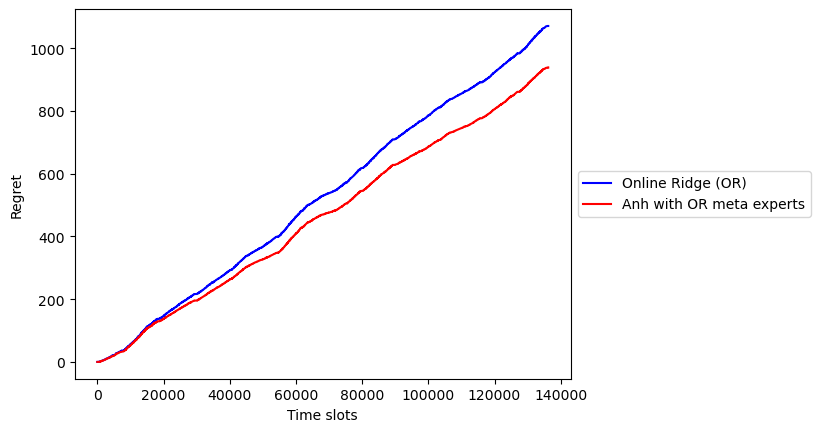

Group number 4, Tg is 14455 

    oridge end regret 91.08333657619607, Anh end regret 71.14291397705256, 

    Anh better Yes 
Oridge regret - Anh regret implementables 19.940422599143517
Relative difference percent 24.58347219533171


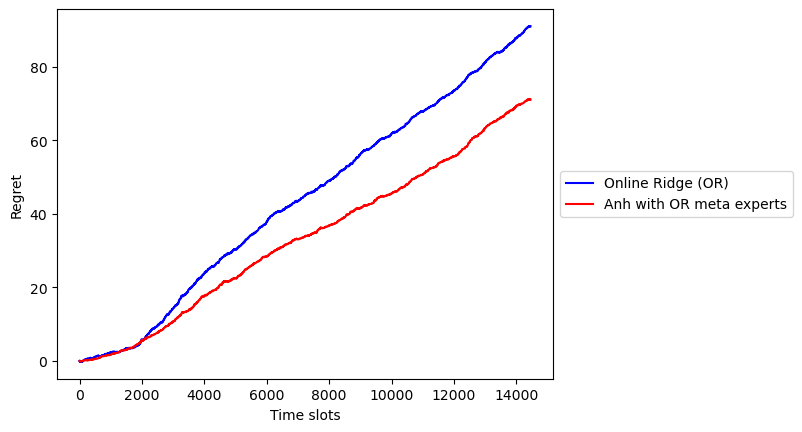

Group number 5, Tg is 726 

    oridge end regret 2.506860615783335, Anh end regret 1.236417284328052, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1.270443331455283
Relative difference percent 67.87865423603623


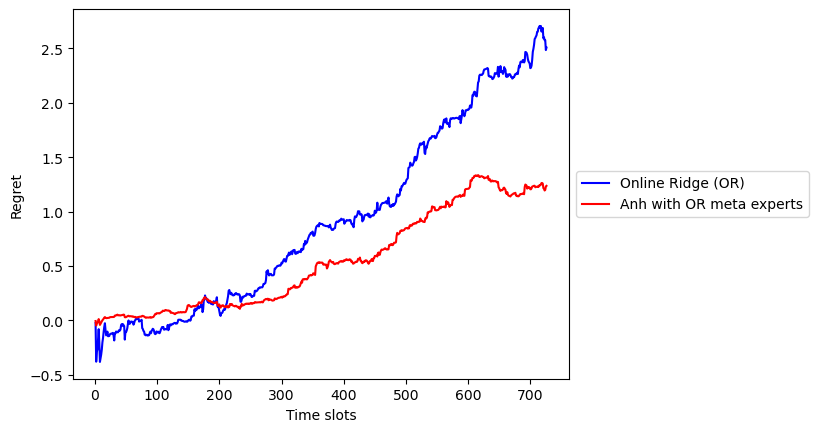

Group number 6, Tg is 2316 

    oridge end regret 13.673292294954265, Anh end regret 8.360966262935214, 

    Anh better Yes 
Oridge regret - Anh regret implementables 5.312326032019051
Relative difference percent 48.21878637815063


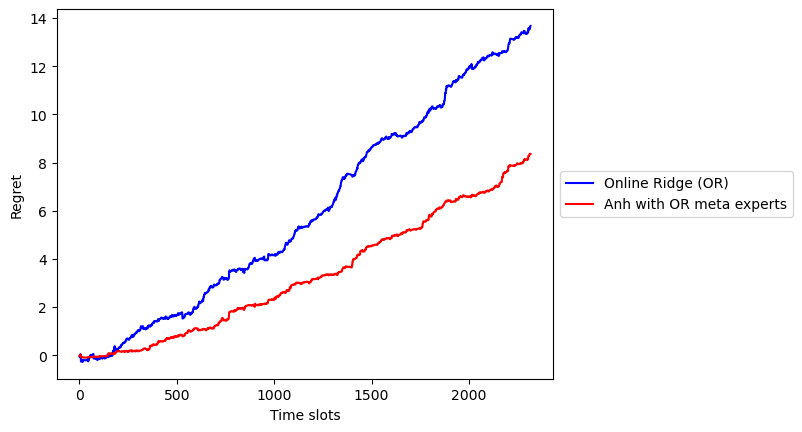

Group number 7, Tg is 100852 

    oridge end regret 1856.5460991641944, Anh end regret 1592.730306001646, 

    Anh better Yes 
Oridge regret - Anh regret implementables 263.8157931625483
Relative difference percent 15.296877499723834


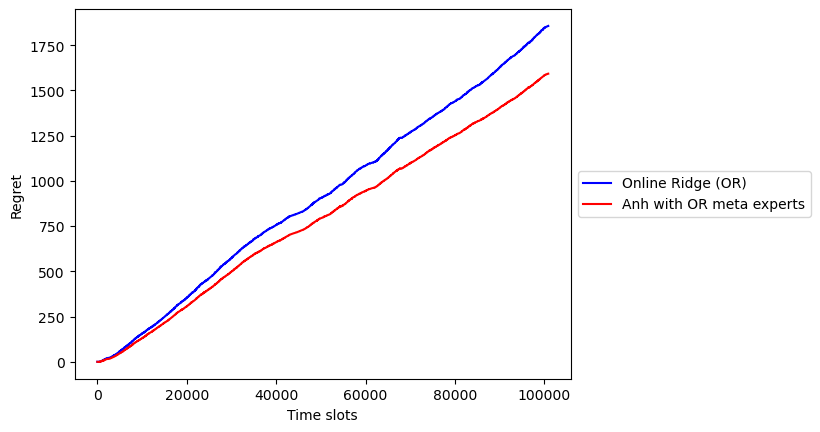

Group number 8, Tg is 2755 

    oridge end regret 13.244923229140312, Anh end regret 9.582714933839327, 

    Anh better Yes 
Oridge regret - Anh regret implementables 3.662208295300985
Relative difference percent 32.08573983129025


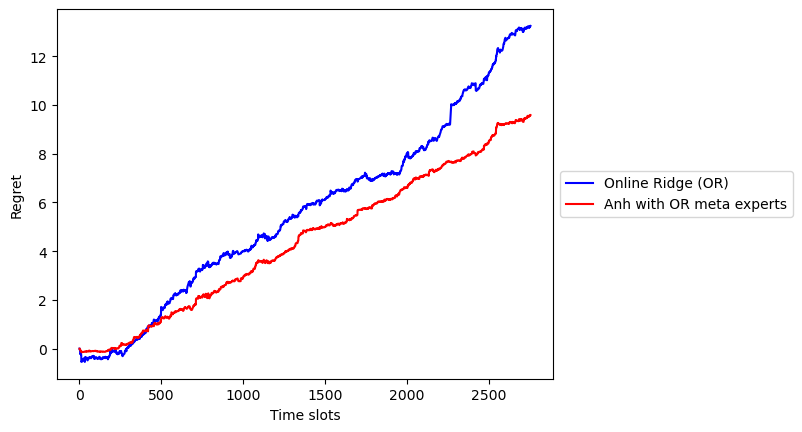

Group number 9, Tg is 97582 

    oridge end regret 860.3519277608511, Anh end regret 606.158381816108, 

    Anh better Yes 
Oridge regret - Anh regret implementables 254.19354594474316
Relative difference percent 34.666451955331944


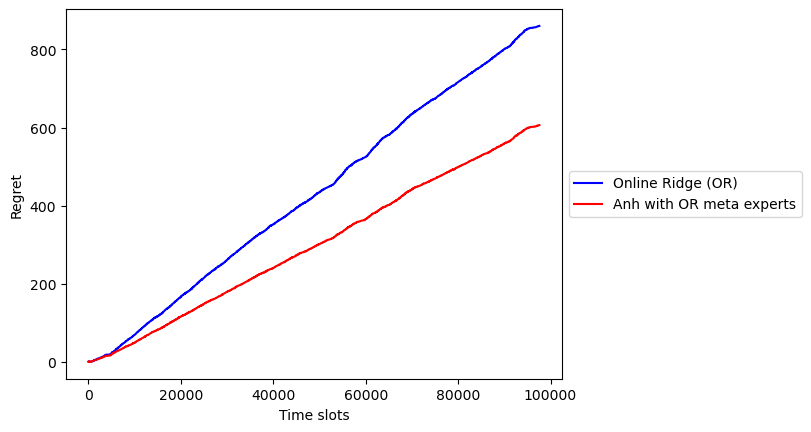

Group number 10, Tg is 168468 

    oridge end regret 1775.3948544313912, Anh end regret 1661.8026908302322, 

    Anh better Yes 
Oridge regret - Anh regret implementables 113.59216360115897
Relative difference percent 6.609580165548086


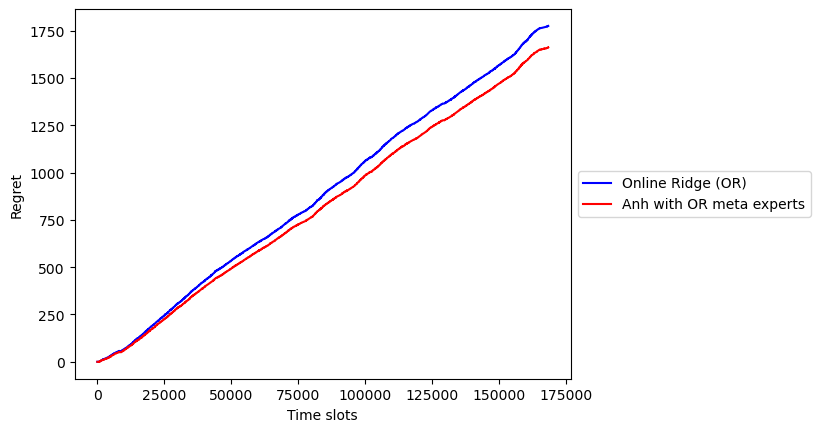

Group number 11, Tg is 1569188 

    oridge end regret 18981.551018925325, Anh end regret 16671.576774916066, 

    Anh better Yes 
Oridge regret - Anh regret implementables 2309.9742440092596
Relative difference percent 12.958045405532568


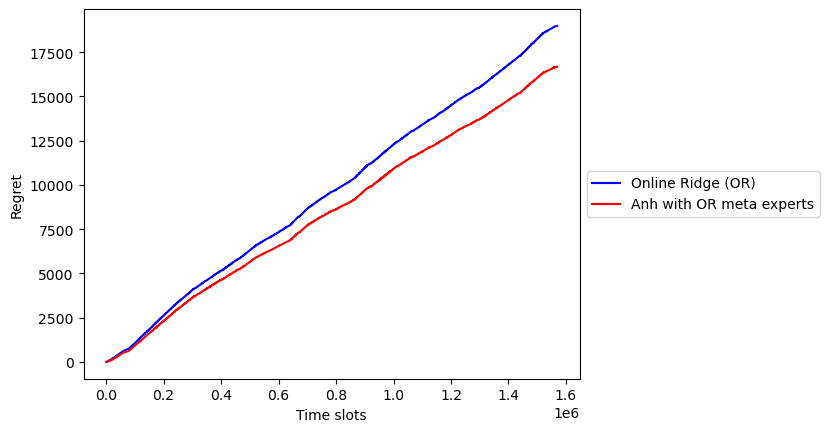

Anh better for 12 out of 12 groups


In [11]:
plot_ORidgevsAnh_together(di_temp2['oridge_implementable'].cumreg_groupwise_oridge, di_temp2['Anh'])

# sort by largest race pop to smallest race pop, unshuffled, undropped

In [ ]:
counts= Counter(data_fil['RAC1P'])
counts.most_common() # 1 white, 9 two or more, 2 black, 6 asian, 8 some other, 3 american indian alone,native hawaii,  

In [38]:
# sort by descending order of race counts
data_fil.sort_values(by='RAC1P', key=lambda x: x.map(x.value_counts()), ascending=False, inplace = True)

/var/folders/1v/82_752zd1cj5trlh7w_qrtj00000gp/T/ipykernel_29684/635166037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fil.sort_values(by='RAC1P', key=lambda x: x.map(x.value_counts()), ascending=False, inplace = True)


In [40]:
data_fil['RAC1P']

359947     1
1483926    1
1484849    1
932901     1
1490610    1
          ..
1577425    4
1488199    4
23997      4
23998      4
23201      4
Name: RAC1P, Length: 1569188, dtype: int64

In [30]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'sort_by_racecounts_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']


In [31]:
alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_gs = {} # di_group sizes descending
di_gs['bls'] = 1
di_gs['Anh'] = 2
di_gs['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_gs, to_shuffle = False, to_drop_groups = False)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [13:59<00:00, 1868.35it/s]


Group number 0, Tg is 805503 

    oridge end regret 9610.03611815055, Anh end regret 9010.861200696036, 

    Anh better Yes 
Oridge regret - Anh regret implementables 599.1749174545148
Relative difference percent 6.435510675933729


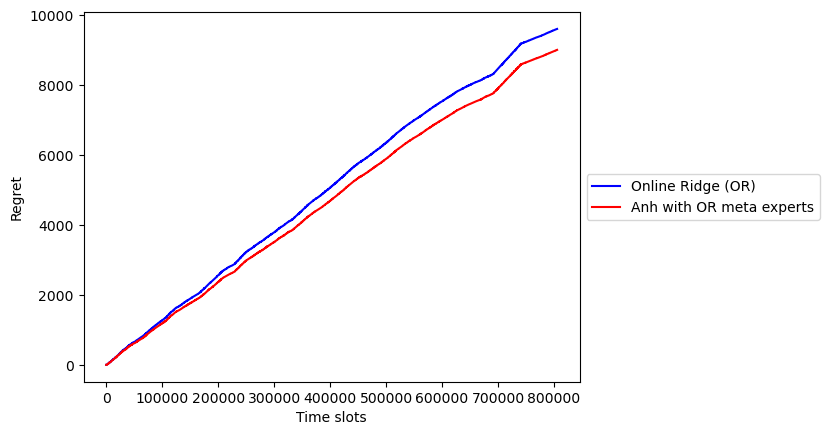

Group number 1, Tg is 763685 

    oridge end regret 8210.420313154424, Anh end regret 8097.189524319387, 

    Anh better Yes 
Oridge regret - Anh regret implementables 113.23078883503695
Relative difference percent 1.3886865084893074


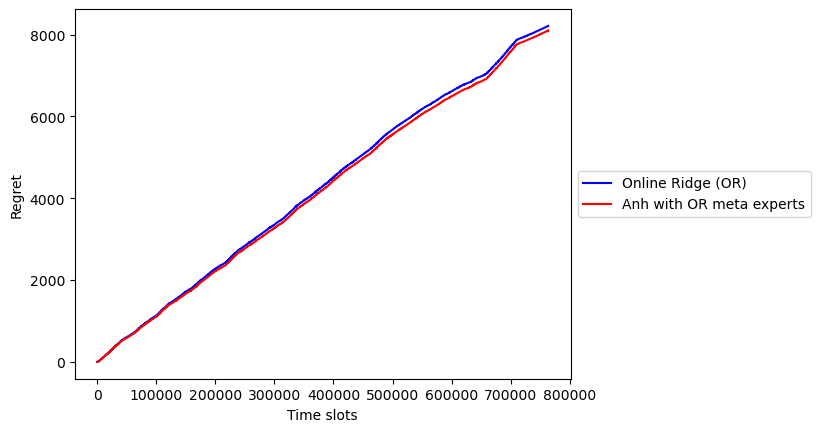

Group number 2, Tg is 1045807 

    oridge end regret 12450.238735950661, Anh end regret 11830.663440799028, 

    Anh better Yes 
Oridge regret - Anh regret implementables 619.5752951516333
Relative difference percent 5.1033959993868026


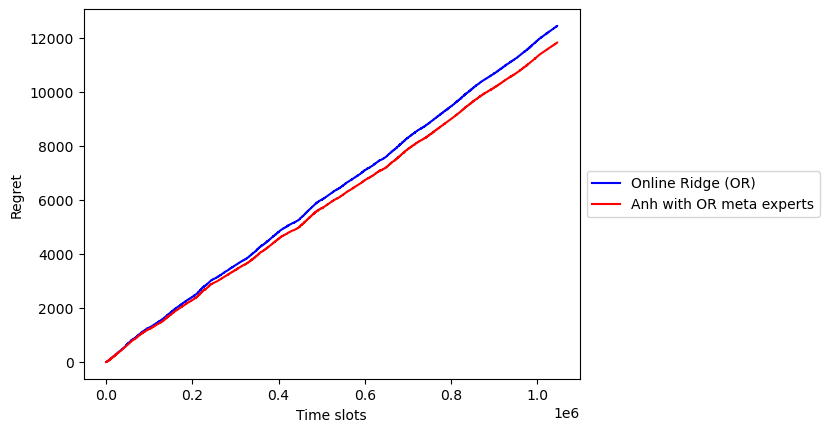

Group number 3, Tg is 136227 

    oridge end regret 970.0705015077347, Anh end regret 960.3569920895407, 

    Anh better Yes 
Oridge regret - Anh regret implementables 9.713509418194008
Relative difference percent 1.0063583792099091


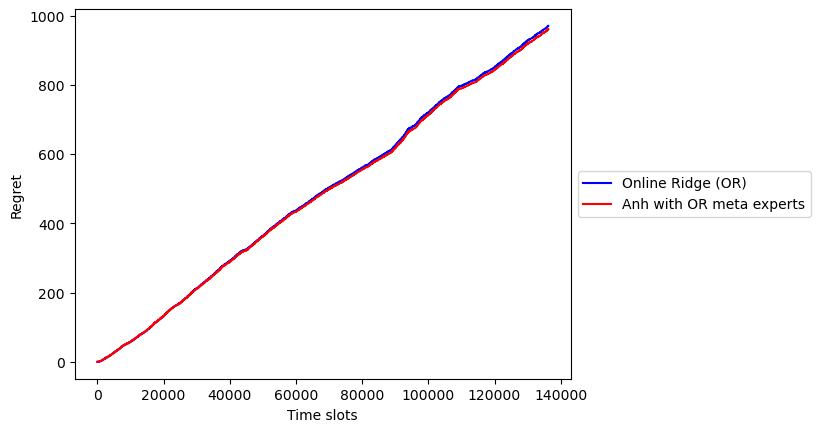

Group number 4, Tg is 14455 

    oridge end regret 71.1397495378992, Anh end regret 70.19591628382005, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.9438332540791521
Relative difference percent 1.3355910535274274


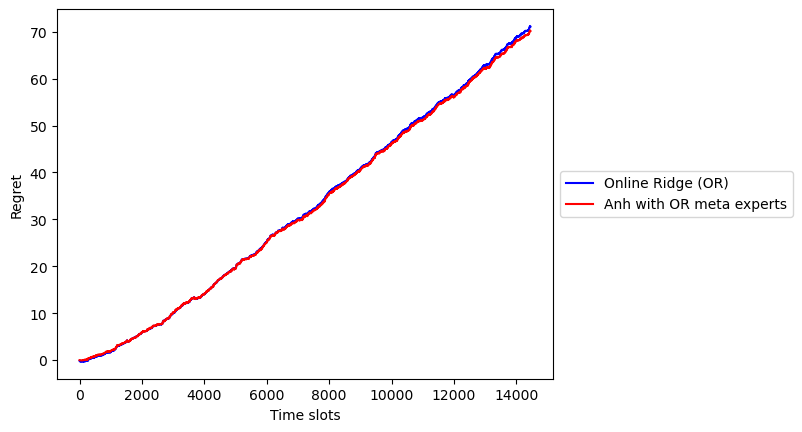

Group number 5, Tg is 726 

    oridge end regret 0.6749472787838897, Anh end regret 1.0837984079915906, 

    Anh better No 
Oridge regret - Anh regret implementables -0.40885112920770084
Relative difference percent 46.49349047812555


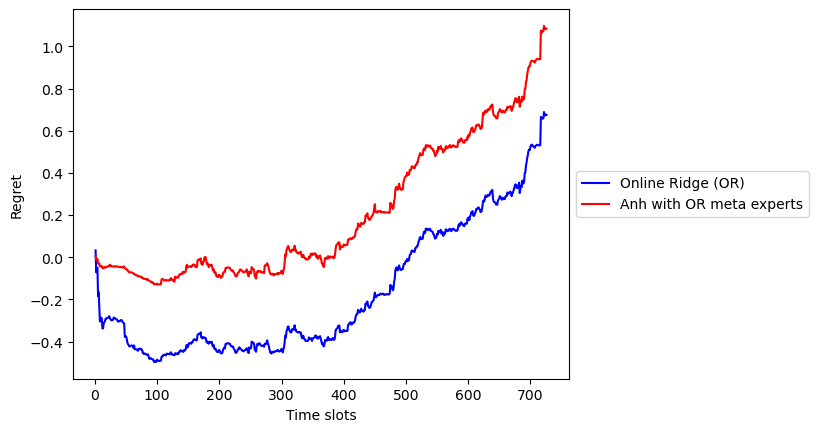

Group number 6, Tg is 2316 

    oridge end regret 8.75938221994835, Anh end regret 8.872507597550054, 

    Anh better No 
Oridge regret - Anh regret implementables -0.11312537760170471
Relative difference percent 1.2831906139685125


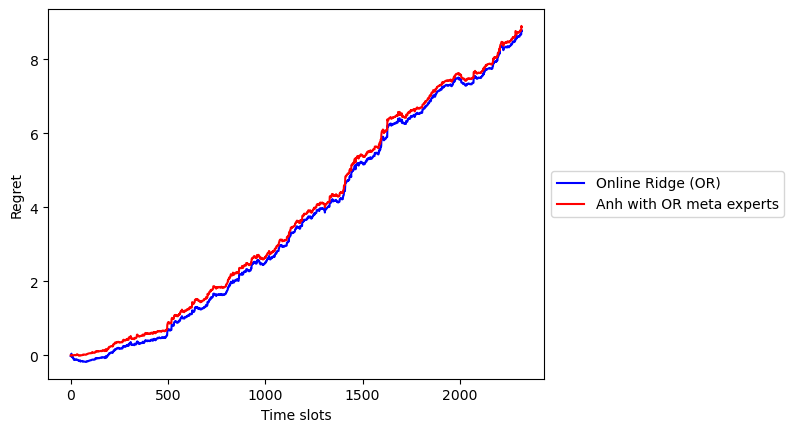

Group number 7, Tg is 100852 

    oridge end regret 1624.5400771564437, Anh end regret 1597.5882457801845, 

    Anh better Yes 
Oridge regret - Anh regret implementables 26.95183137625918
Relative difference percent 1.6729210431753037


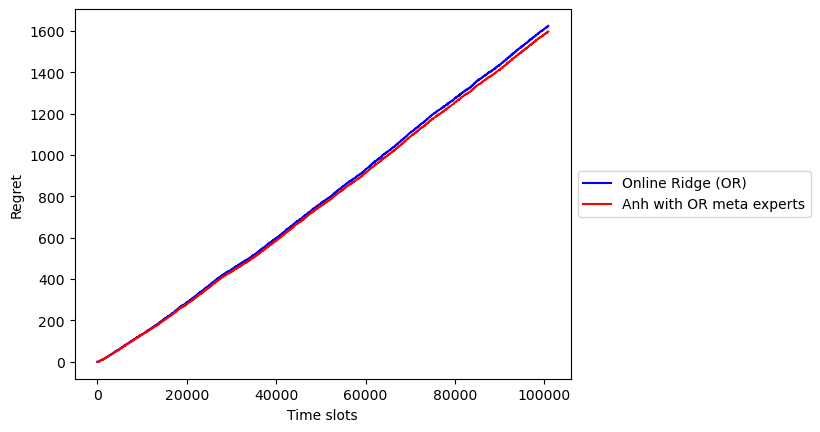

Group number 8, Tg is 2755 

    oridge end regret 9.76120560247854, Anh end regret 10.19107303178717, 

    Anh better No 
Oridge regret - Anh regret implementables -0.4298674293086293
Relative difference percent 4.308955755763978


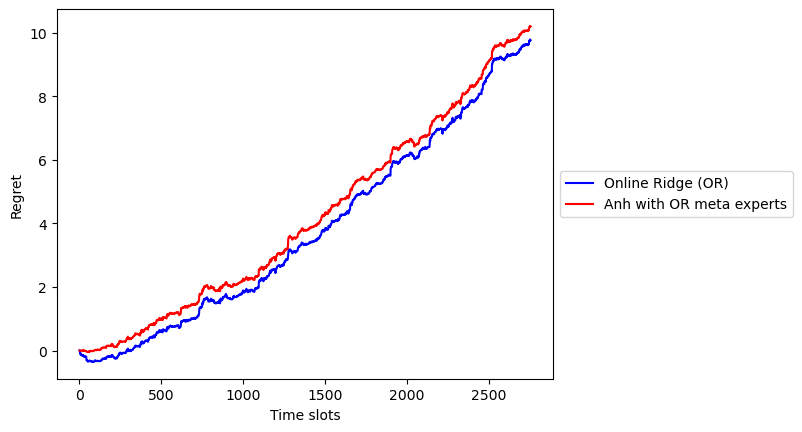

Group number 9, Tg is 97582 

    oridge end regret 579.4012440514684, Anh end regret 570.2089749385091, 

    Anh better Yes 
Oridge regret - Anh regret implementables 9.192269112959366
Relative difference percent 1.5991975299307088


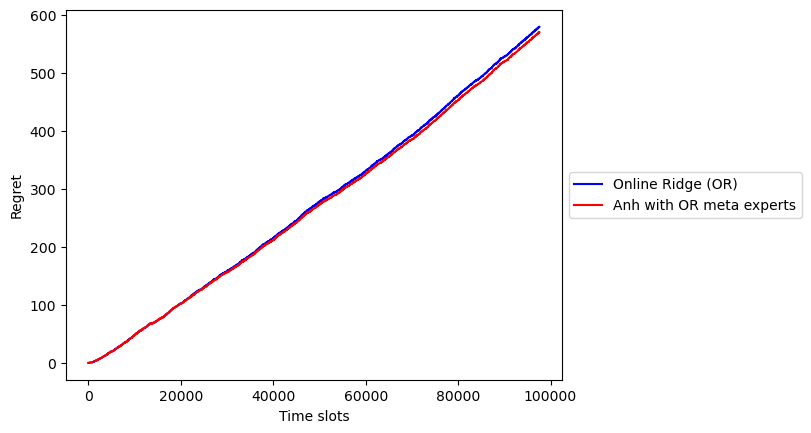

Group number 10, Tg is 168468 

    oridge end regret 1630.3527215208683, Anh end regret 1583.3719096120417, 

    Anh better Yes 
Oridge regret - Anh regret implementables 46.98081190882658
Relative difference percent 2.9237608881421053


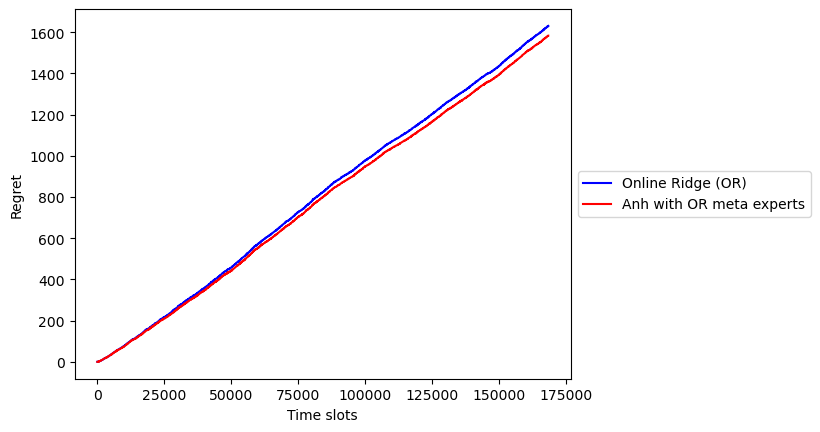

Group number 11, Tg is 1569188 

    oridge end regret 17587.122841234202, Anh end regret 16874.717134950646, 

    Anh better Yes 
Oridge regret - Anh regret implementables 712.4057062835564
Relative difference percent 4.134461228859925


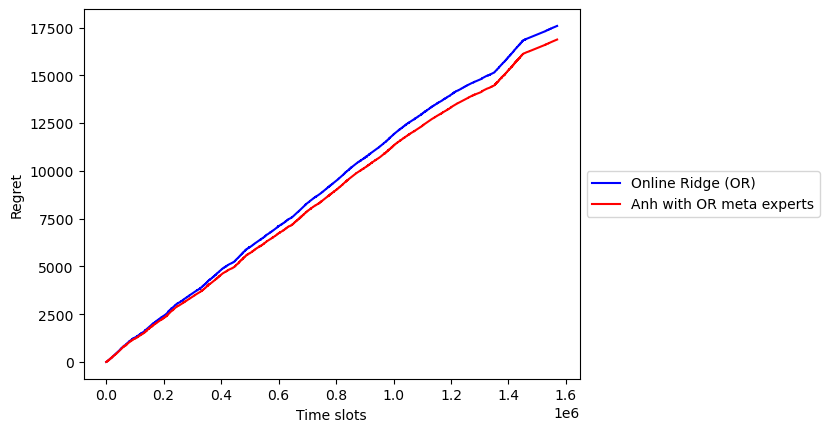

Anh better for 9 out of 12 groups


In [37]:
plot_ORidgevsAnh_together(di_gs['oridge_implementable'].cumreg_groupwise_oridge, di_gs['Anh'])

# sort by largest race pop to smallest, dropped sensitive columns

In [43]:
data_fil.sort_values(by='RAC1P', key=lambda x: x.map(x.value_counts()), ascending=False, inplace = True)
data_fil['RAC1P'].head()

/var/folders/1v/82_752zd1cj5trlh7w_qrtj00000gp/T/ipykernel_29684/2886995473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fil.sort_values(by='RAC1P', key=lambda x: x.map(x.value_counts()), ascending=False, inplace = True)


359947     1
1342986    1
1342811    1
1343071    1
1343078    1
Name: RAC1P, dtype: int64

In [44]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'sort_by_racecounts_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)

di_gsd = {} # di_group sizes descending, dropped
di_gsd['bls'] = 1
di_gsd['Anh'] = 2
di_gsd['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_gsd, to_shuffle = False, to_drop_groups = True)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [13:53<00:00, 1882.89it/s]


Group number 0, Tg is 805503 

    oridge end regret 9032.37894593758, Anh end regret 8982.949999228389, 

    Anh better Yes 
Oridge regret - Anh regret implementables 49.42894670919122
Relative difference percent 0.5487432048522703


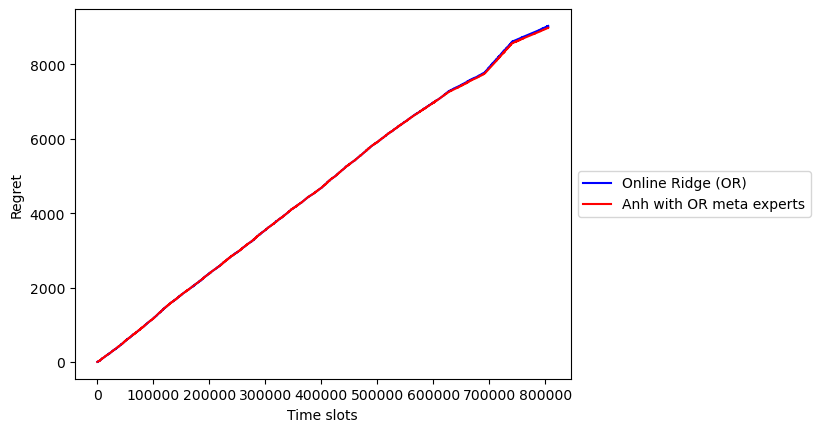

Group number 1, Tg is 763685 

    oridge end regret 8089.809909244168, Anh end regret 8073.434172321371, 

    Anh better Yes 
Oridge regret - Anh regret implementables 16.375736922796932
Relative difference percent 0.20262933406386832


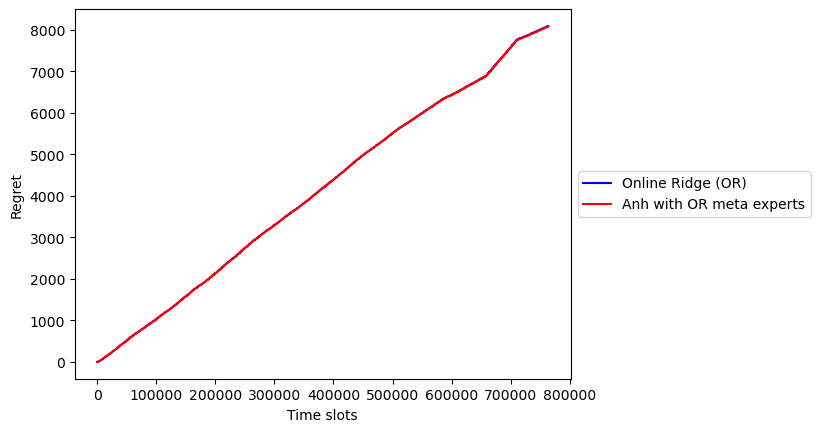

Group number 2, Tg is 1045807 

    oridge end regret 11973.85387766693, Anh end regret 11973.719028284984, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.13484938194596907
Relative difference percent 0.0011262050018643326


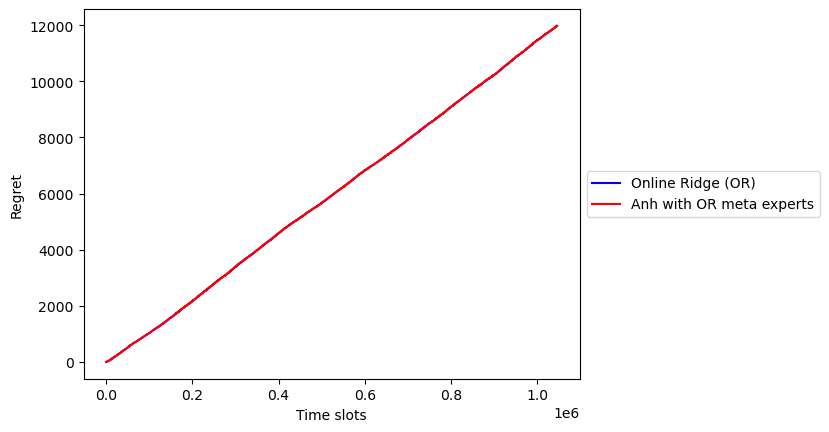

Group number 3, Tg is 136227 

    oridge end regret 1002.3731141627882, Anh end regret 988.3494669647803, 

    Anh better Yes 
Oridge regret - Anh regret implementables 14.023647198007893
Relative difference percent 1.408900198446007


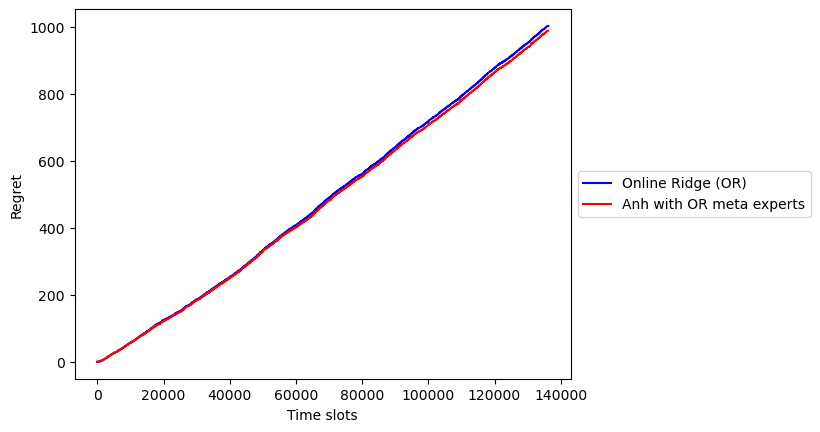

Group number 4, Tg is 14455 

    oridge end regret 70.43860439840654, Anh end regret 70.51503602573962, 

    Anh better No 
Oridge regret - Anh regret implementables -0.07643162733307918
Relative difference percent 0.1084493129841661


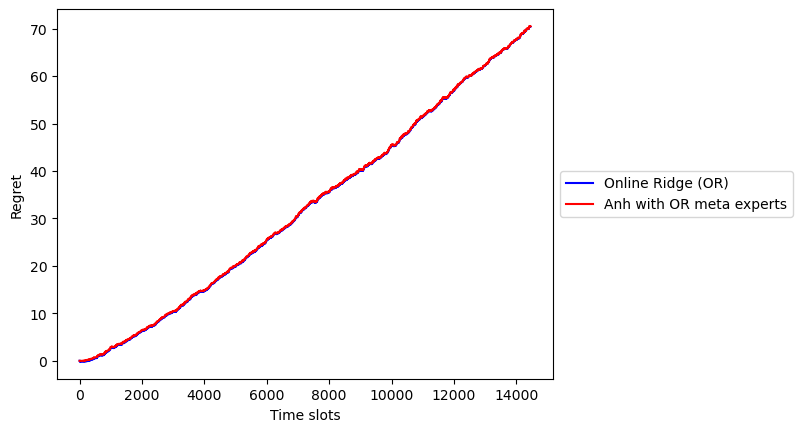

Group number 5, Tg is 726 

    oridge end regret 0.9496912809654461, Anh end regret 1.1771182423458235, 

    Anh better No 
Oridge regret - Anh regret implementables -0.22742696138037743
Relative difference percent 21.386678862175877


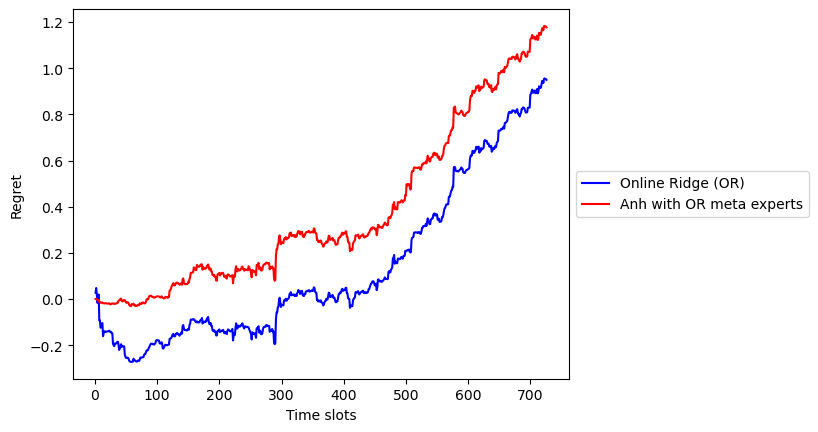

Group number 6, Tg is 2316 

    oridge end regret 8.418126049396776, Anh end regret 7.886441716988621, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.5316843324081546
Relative difference percent 6.521906499162905


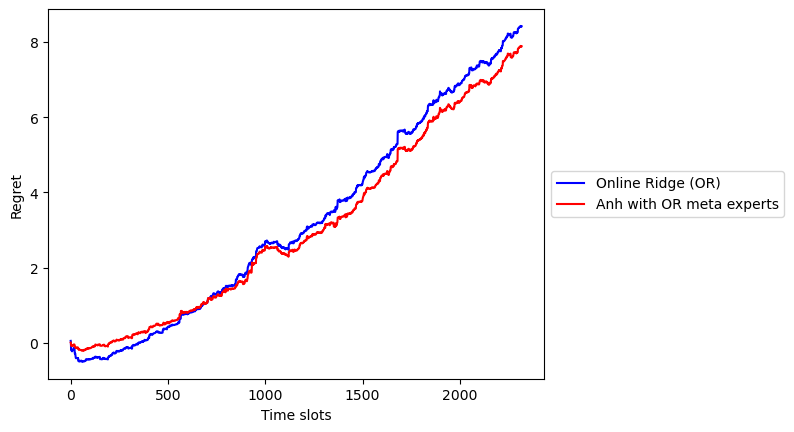

Group number 7, Tg is 100852 

    oridge end regret 1621.0536073149897, Anh end regret 1611.6418149032434, 

    Anh better Yes 
Oridge regret - Anh regret implementables 9.411792411746319
Relative difference percent 0.5822876072431266


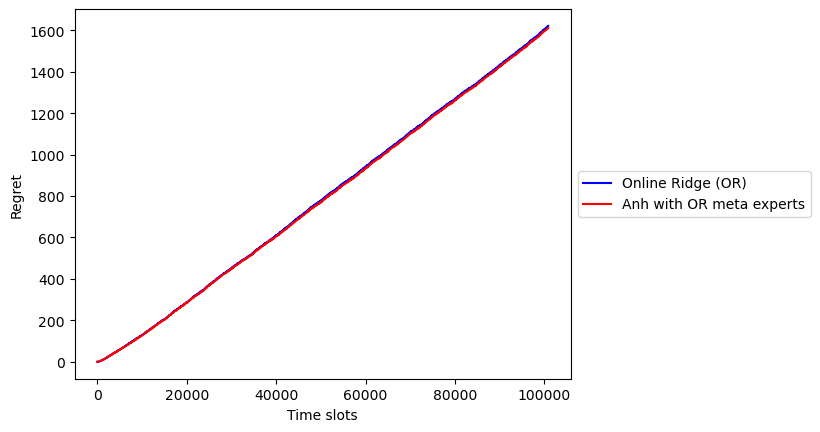

Group number 8, Tg is 2755 

    oridge end regret 9.819187443370339, Anh end regret 9.648696406617887, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.17049103675245192
Relative difference percent 1.7515107247011341


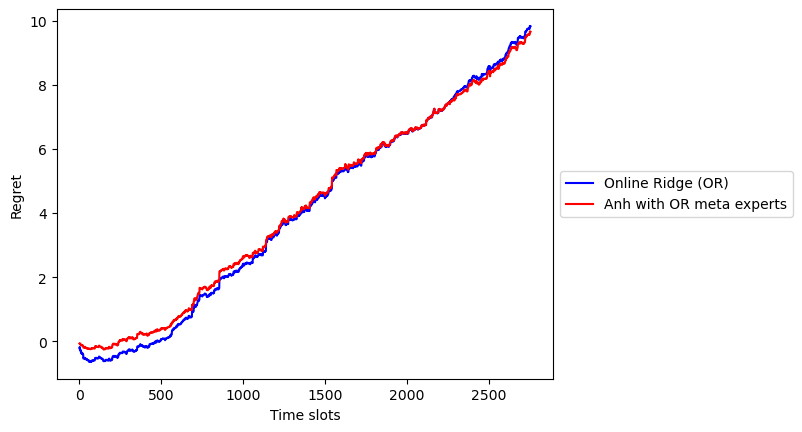

Group number 9, Tg is 97582 

    oridge end regret 581.6297174749113, Anh end regret 566.5173490856778, 

    Anh better Yes 
Oridge regret - Anh regret implementables 15.112368389233552
Relative difference percent 2.632479554122704


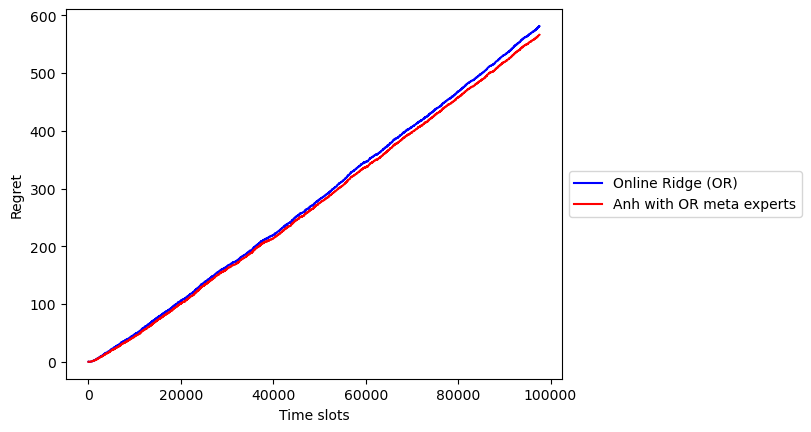

Group number 10, Tg is 168468 

    oridge end regret 1625.3056007301761, Anh end regret 1598.5818912597538, 

    Anh better Yes 
Oridge regret - Anh regret implementables 26.723709470422364
Relative difference percent 1.6578562084948738


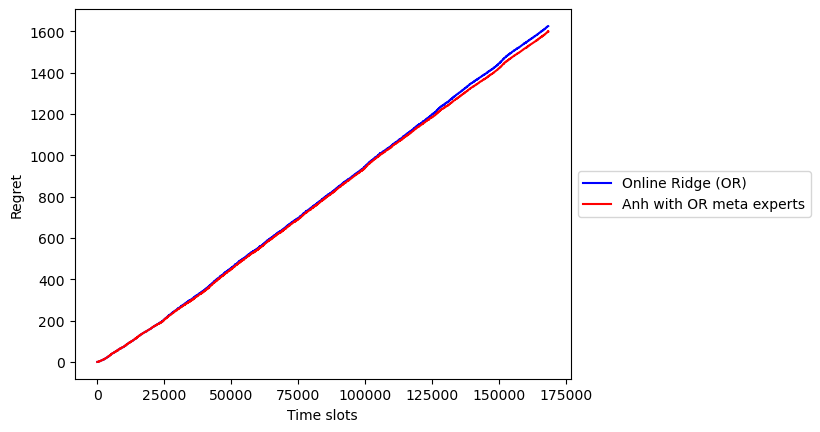

Group number 11, Tg is 1569188 

    oridge end regret 17134.602811120807, Anh end regret 17068.798127491413, 

    Anh better Yes 
Oridge regret - Anh regret implementables 65.80468362939428
Relative difference percent 0.3847844472980894


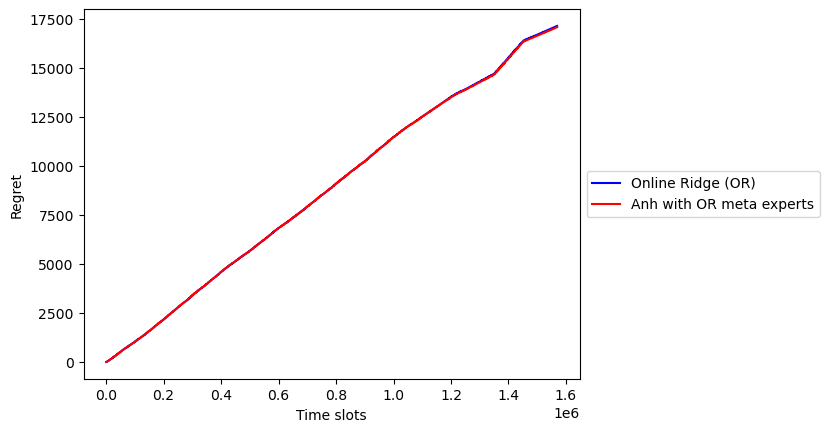

Anh better for 10 out of 12 groups


In [45]:
plot_ORidgevsAnh_together(di_gsd['oridge_implementable'].cumreg_groupwise_oridge, di_gsd['Anh'])

# sort by largest sex to smallest, undropped

In [41]:
data_fil.sort_values(by='SEX', key=lambda x: x.map(x.value_counts()), ascending=False, inplace = True)

/var/folders/1v/82_752zd1cj5trlh7w_qrtj00000gp/T/ipykernel_29684/1575158186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fil.sort_values(by='SEX', key=lambda x: x.map(x.value_counts()), ascending=False, inplace = True)


In [33]:
counts= Counter(data_fil['SEX'])
counts.most_common() #  

[(1, 805503), (2, 763685)]

In [42]:
data_fil['SEX']

359947     1
1214093    1
1215602    1
1215595    1
1215600    1
          ..
706251     2
706248     2
706245     2
706209     2
23201      2
Name: SEX, Length: 1569188, dtype: int64

In [35]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'sort_by_sex_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_sexs = {} # di sex descending, undropped
di_sexs['bls'] = 1
di_sexs['Anh'] = 2
di_sexs['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_sexs, to_shuffle = False, to_drop_groups = False)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [13:58<00:00, 1872.39it/s]


Group number 0, Tg is 805503 

    oridge end regret 9251.68988080795, Anh end regret 8864.822853391019, 

    Anh better Yes 
Oridge regret - Anh regret implementables 386.8670274169308
Relative difference percent 4.270877437539431


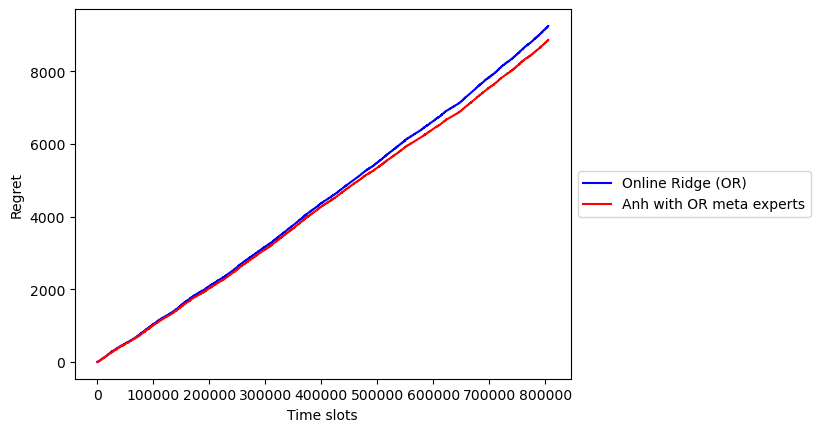

Group number 1, Tg is 763685 

    oridge end regret 8166.4118815488455, Anh end regret 8085.972027582664, 

    Anh better Yes 
Oridge regret - Anh regret implementables 80.43985396618154
Relative difference percent 0.9898837538656207


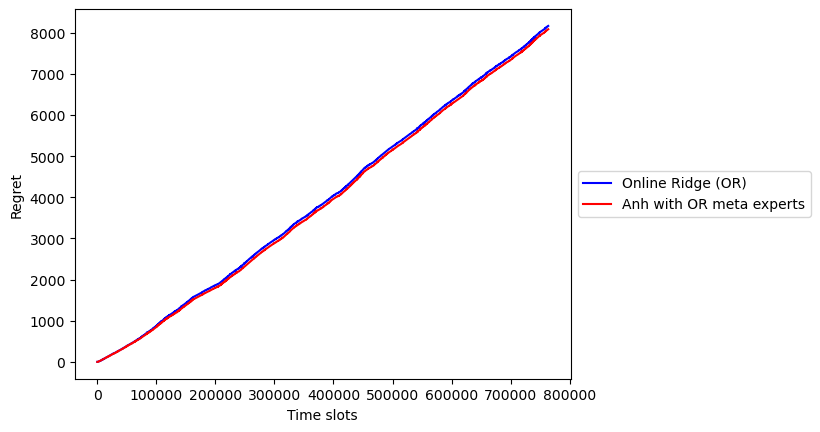

Group number 2, Tg is 1045807 

    oridge end regret 12208.84826345907, Anh end regret 12081.86147539103, 

    Anh better Yes 
Oridge regret - Anh regret implementables 126.98678806803946
Relative difference percent 1.0455584825085553


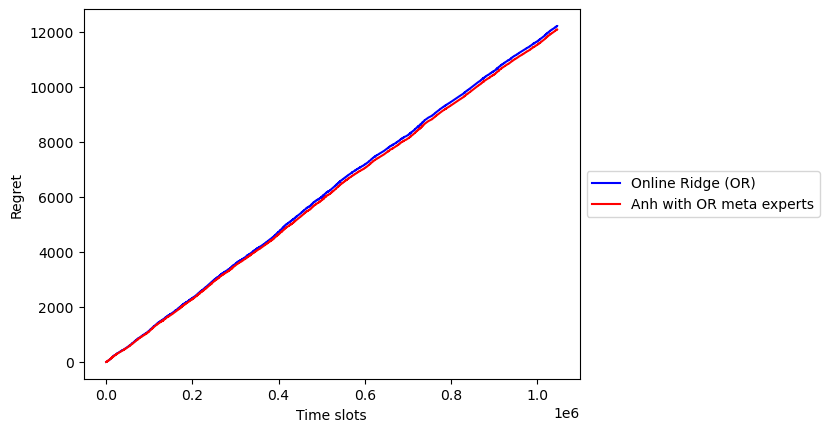

Group number 3, Tg is 136227 

    oridge end regret 1018.321609912075, Anh end regret 978.7061119721247, 

    Anh better Yes 
Oridge regret - Anh regret implementables 39.615497939950274
Relative difference percent 3.967445970411765


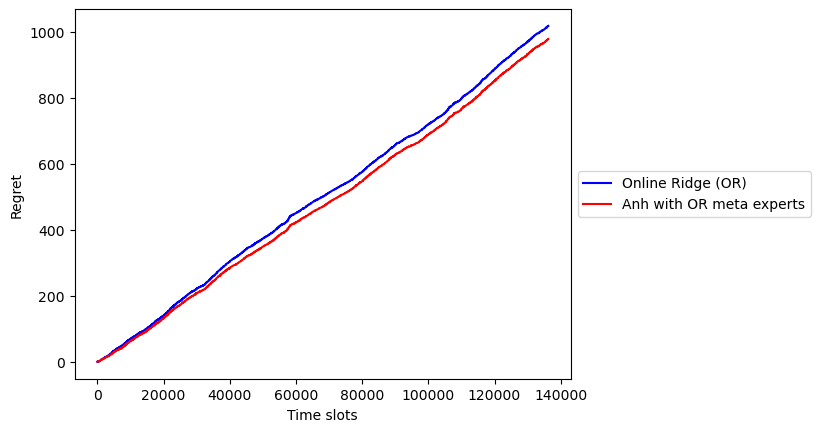

Group number 4, Tg is 14455 

    oridge end regret 89.40749496379226, Anh end regret 71.53211001853958, 

    Anh better Yes 
Oridge regret - Anh regret implementables 17.875384945252677
Relative difference percent 22.21378006639827


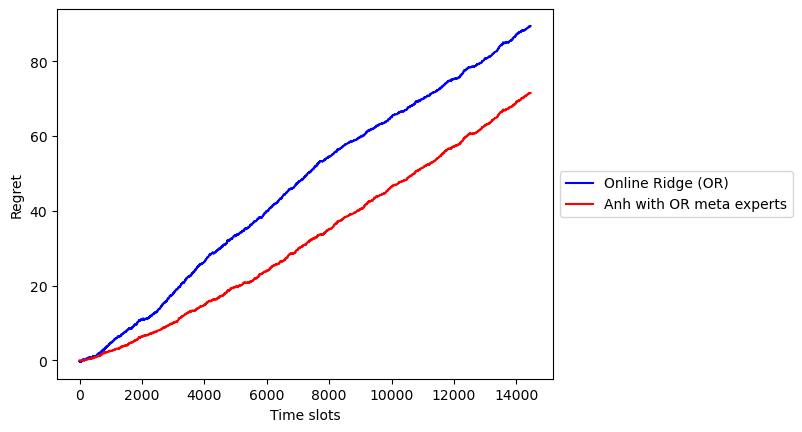

Group number 5, Tg is 726 

    oridge end regret 1.538613145113029, Anh end regret 0.8700837257368796, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.6685294193761493
Relative difference percent 55.509634895673585


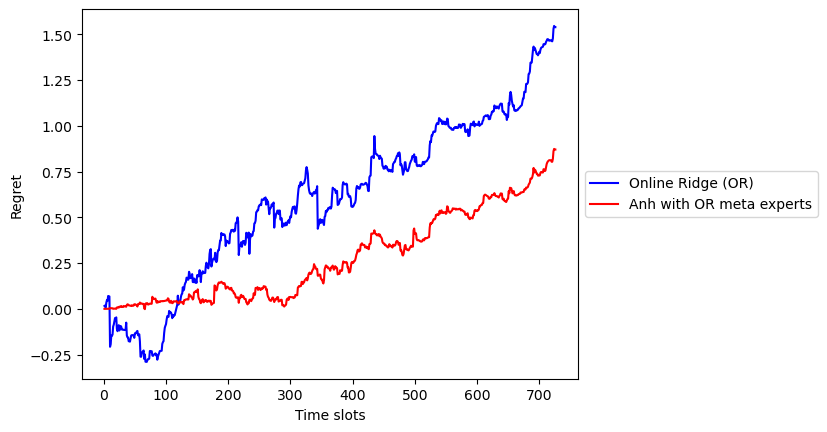

Group number 6, Tg is 2316 

    oridge end regret 10.665449245430217, Anh end regret 8.266627290967769, 

    Anh better Yes 
Oridge regret - Anh regret implementables 2.3988219544624485
Relative difference percent 25.341350694949682


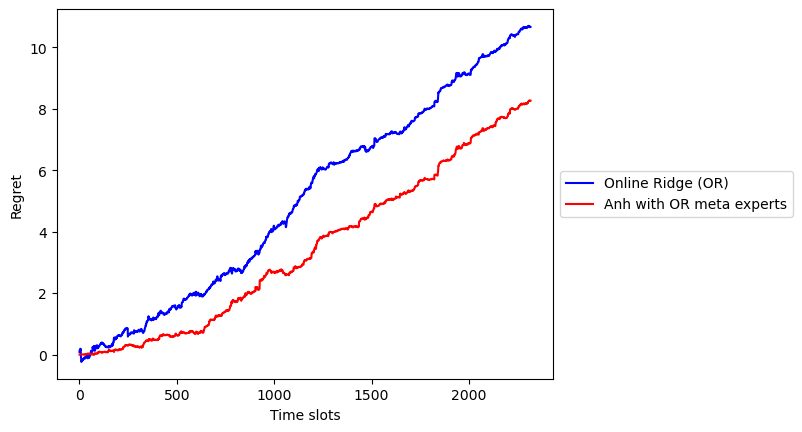

Group number 7, Tg is 100852 

    oridge end regret 1848.2230881125051, Anh end regret 1641.3318935899788, 

    Anh better Yes 
Oridge regret - Anh regret implementables 206.89119452252635
Relative difference percent 11.85774092154228


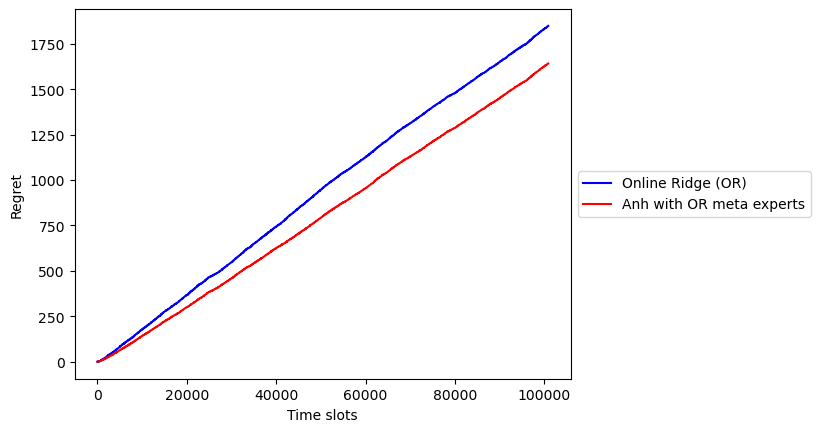

Group number 8, Tg is 2755 

    oridge end regret 9.822196178691357, Anh end regret 10.517327728822877, 

    Anh better No 
Oridge regret - Anh regret implementables -0.6951315501315207
Relative difference percent 6.835278478418183


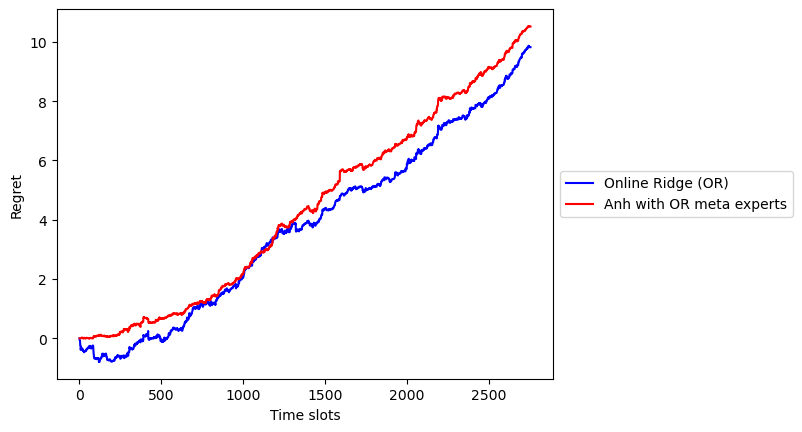

Group number 9, Tg is 97582 

    oridge end regret 607.8313642517617, Anh end regret 573.9571709187837, 

    Anh better Yes 
Oridge regret - Anh regret implementables 33.87419333297794
Relative difference percent 5.7326996031636925


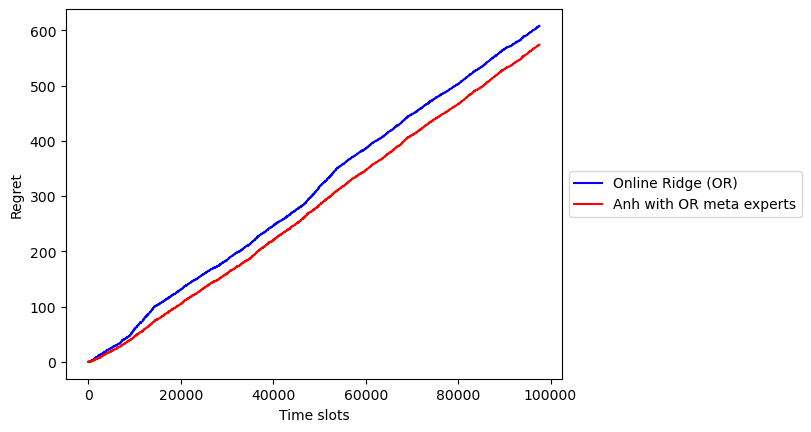

Group number 10, Tg is 168468 

    oridge end regret 1654.450095347122, Anh end regret 1614.7584925969818, 

    Anh better Yes 
Oridge regret - Anh regret implementables 39.69160275014019
Relative difference percent 2.428208643309659


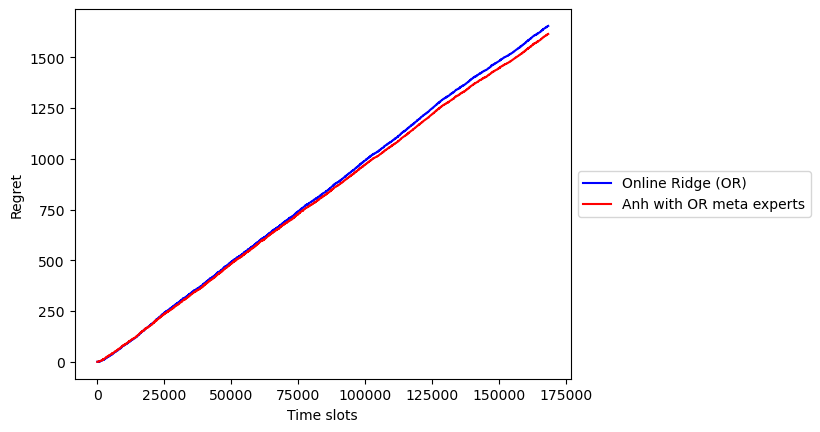

Group number 11, Tg is 1569188 

    oridge end regret 17474.988281141697, Anh end regret 17007.68139976001, 

    Anh better Yes 
Oridge regret - Anh regret implementables 467.30688138168625
Relative difference percent 2.7103869027896357


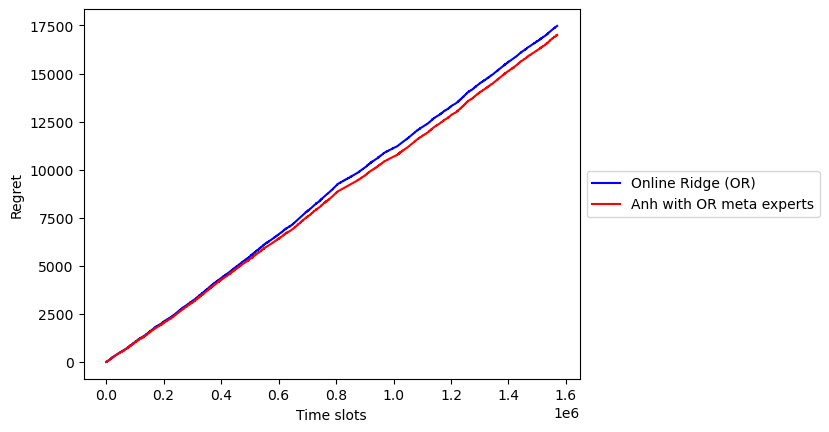

Anh better for 11 out of 12 groups


In [36]:
plot_ORidgevsAnh_together(di_sexs['oridge_implementable'].cumreg_groupwise_oridge, di_sexs['Anh'])

# sort by largest sex to smallest, drop sensitive columns

In [46]:
data_fil.sort_values(by='SEX', key=lambda x: x.map(x.value_counts()), ascending=False, inplace = True)

/var/folders/1v/82_752zd1cj5trlh7w_qrtj00000gp/T/ipykernel_29684/1575158186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fil.sort_values(by='SEX', key=lambda x: x.map(x.value_counts()), ascending=False, inplace = True)


In [47]:
data_fil['SEX'].head()

359947    1
260616    1
518621    1
58629     1
515708    1
Name: SEX, dtype: int64

In [48]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'sort_by_sex_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_sexs_d = {} # di sex descending, dropped
di_sexs_d['bls'] = 1
di_sexs_d['Anh'] = 2
di_sexs_d['oridge_implementable'] = 3
alm_obj.build_models(di_to_fill = di_sexs_d, to_shuffle = False, to_drop_groups = True)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [14:02<00:00, 1863.51it/s]


Group number 0, Tg is 805503 

    oridge end regret 9003.191521964472, Anh end regret 9004.025995163858, 

    Anh better No 
Oridge regret - Anh regret implementables -0.834473199385684
Relative difference percent 0.0092682081347875


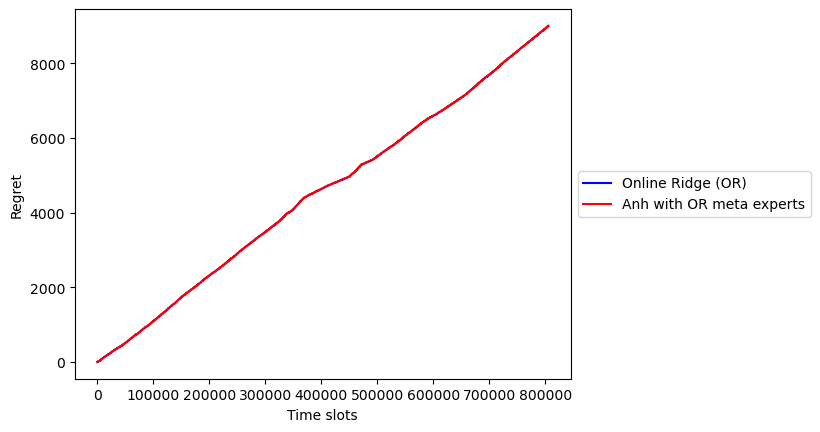

Group number 1, Tg is 763685 

    oridge end regret 8075.41608542225, Anh end regret 8036.518540509958, 

    Anh better Yes 
Oridge regret - Anh regret implementables 38.89754491229178
Relative difference percent 0.4828413944739579


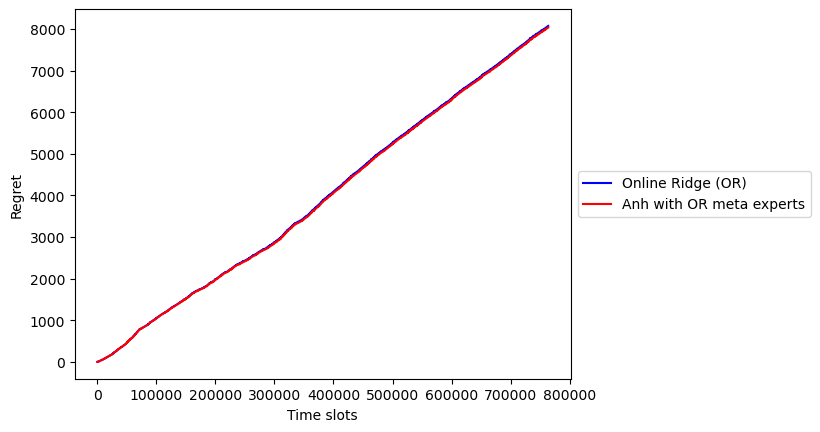

Group number 2, Tg is 1045807 

    oridge end regret 12039.416650390373, Anh end regret 12021.685718094694, 

    Anh better Yes 
Oridge regret - Anh regret implementables 17.73093229567894
Relative difference percent 0.14738254319471827


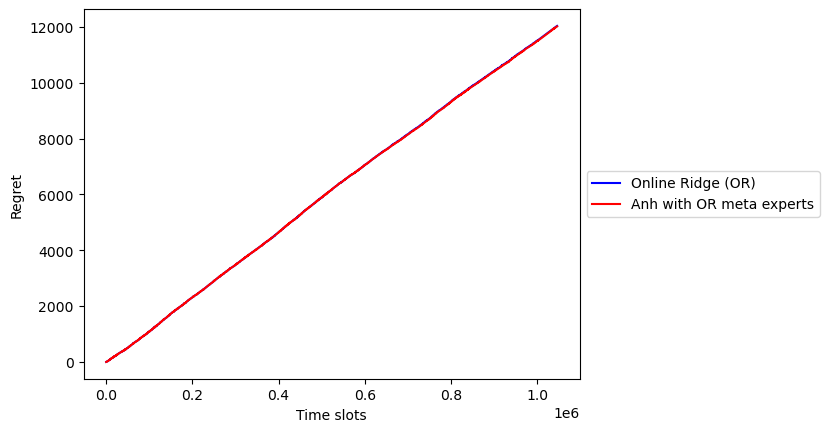

Group number 3, Tg is 136227 

    oridge end regret 1003.1408028004803, Anh end regret 998.829857909494, 

    Anh better Yes 
Oridge regret - Anh regret implementables 4.31094489098632
Relative difference percent 0.4306701367399158


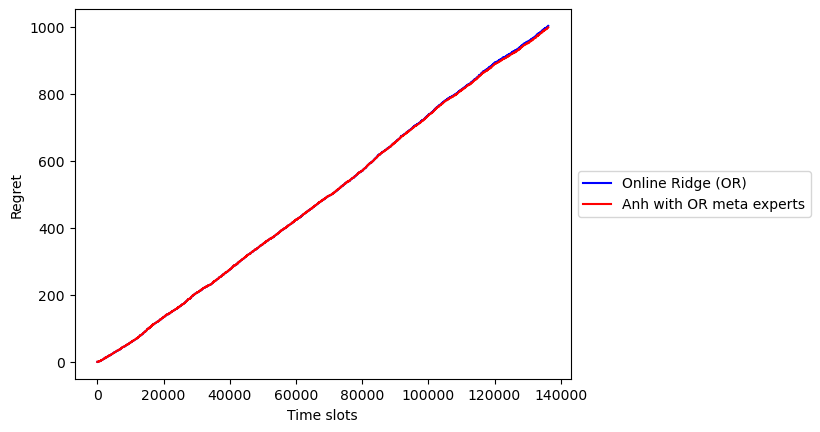

Group number 4, Tg is 14455 

    oridge end regret 69.75529831414565, Anh end regret 70.15233899147847, 

    Anh better No 
Oridge regret - Anh regret implementables -0.397040677332825
Relative difference percent 0.5675754161518736


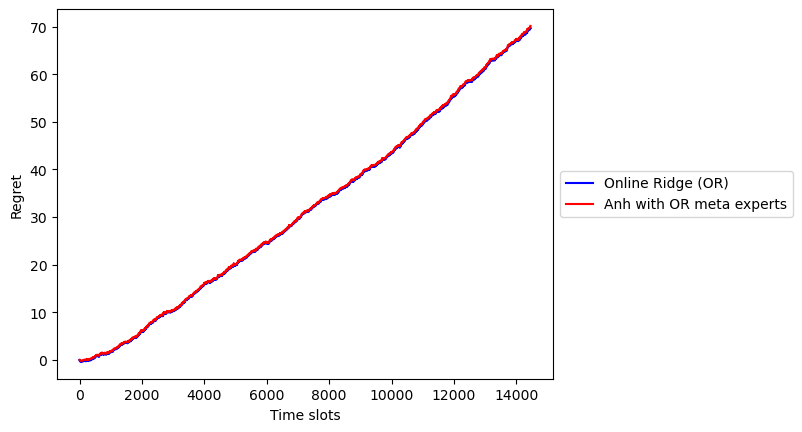

Group number 5, Tg is 726 

    oridge end regret 0.4038395343807366, Anh end regret 0.684279252403897, 

    Anh better No 
Oridge regret - Anh regret implementables -0.28043971802316037
Relative difference percent 51.54579103479197


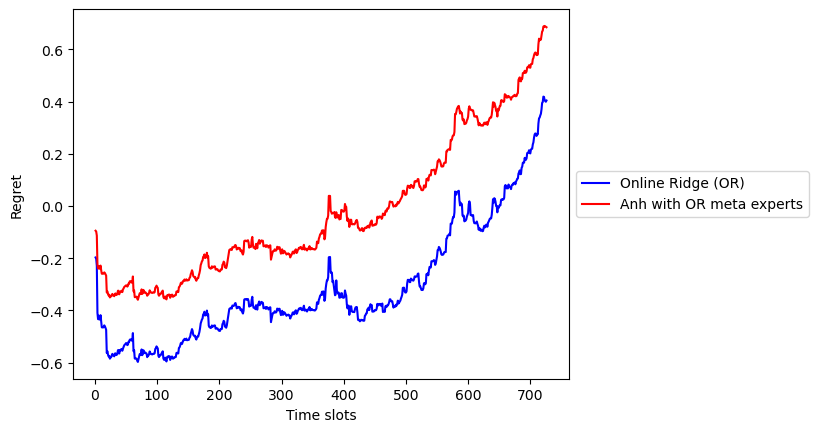

Group number 6, Tg is 2316 

    oridge end regret 8.595865029765449, Anh end regret 8.63213695959844, 

    Anh better No 
Oridge regret - Anh regret implementables -0.0362719298329921
Relative difference percent 0.4210810964078763


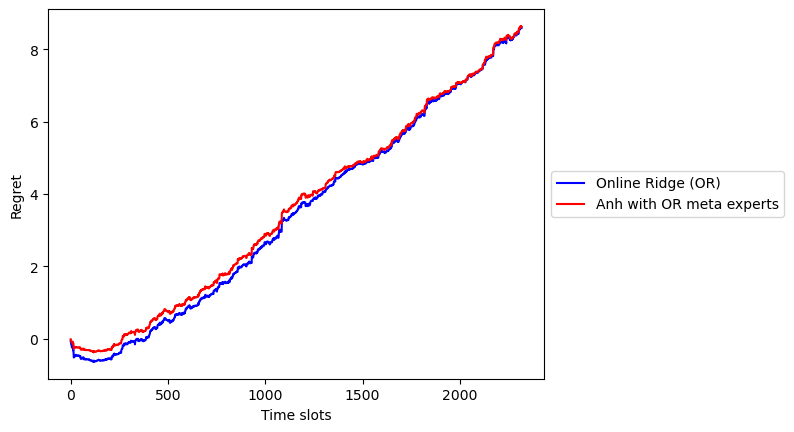

Group number 7, Tg is 100852 

    oridge end regret 1632.6341016154752, Anh end regret 1621.2351875992613, 

    Anh better Yes 
Oridge regret - Anh regret implementables 11.398914016213894
Relative difference percent 0.700637487436677


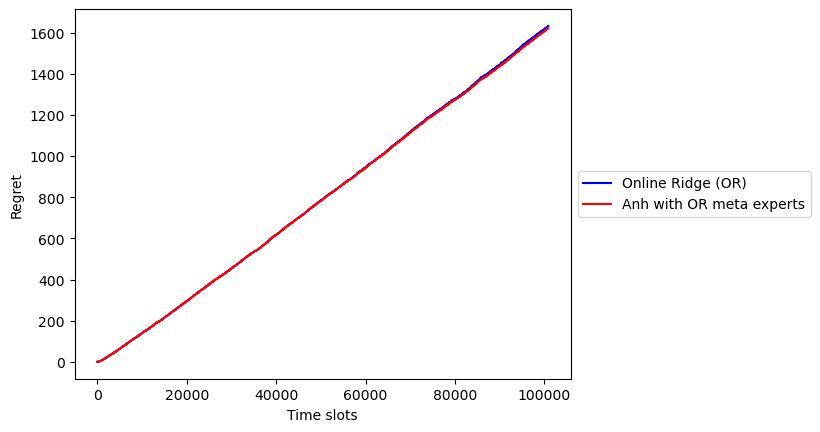

Group number 8, Tg is 2755 

    oridge end regret 9.52311518498226, Anh end regret 10.014328079333254, 

    Anh better No 
Oridge regret - Anh regret implementables -0.49121289435099413
Relative difference percent 5.028425548886205


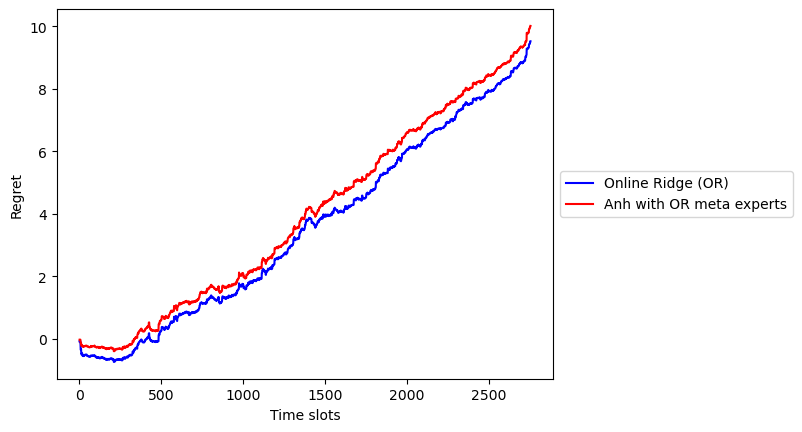

Group number 9, Tg is 97582 

    oridge end regret 576.7308702608018, Anh end regret 575.877942632294, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.852927628507814
Relative difference percent 0.14799949800261034


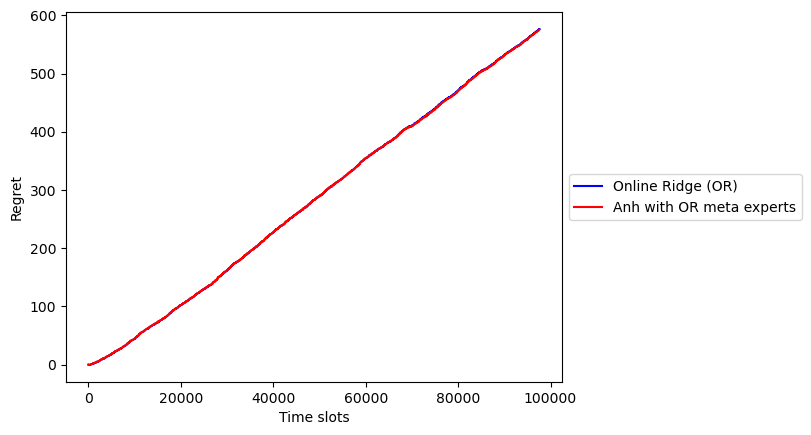

Group number 10, Tg is 168468 

    oridge end regret 1614.7608828015882, Anh end regret 1609.7865647017352, 

    Anh better Yes 
Oridge regret - Anh regret implementables 4.974318099853008
Relative difference percent 0.3085281380309341


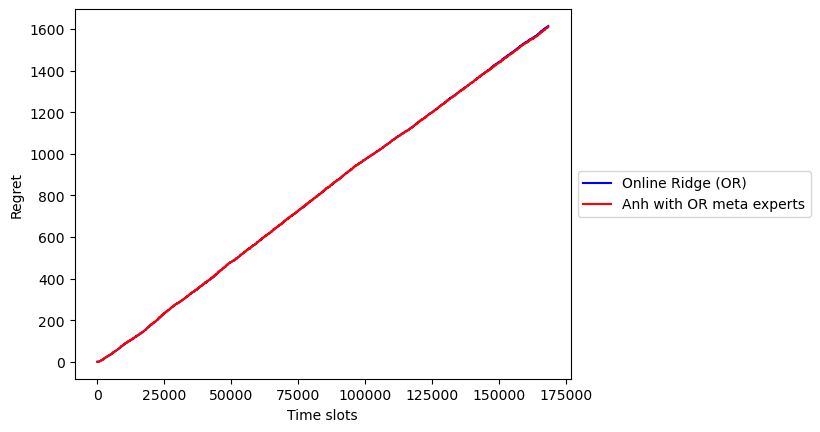

Group number 11, Tg is 1569188 

    oridge end regret 17133.37509102931, Anh end regret 17095.31201931837, 

    Anh better Yes 
Oridge regret - Anh regret implementables 38.06307171093795
Relative difference percent 0.22240450875739898


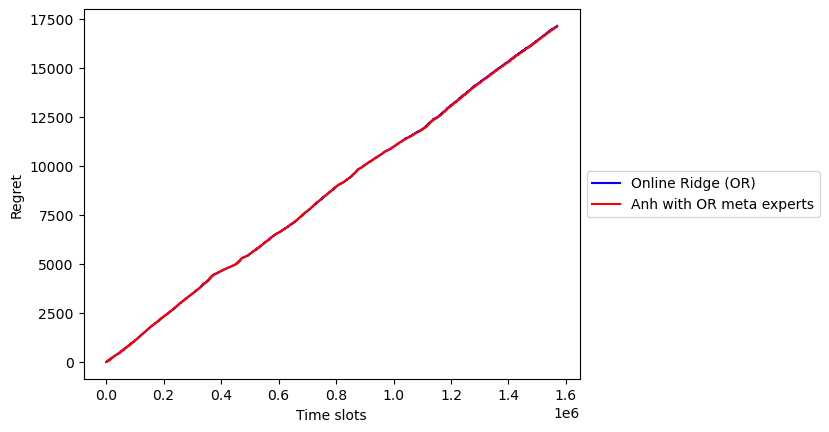

Anh better for 7 out of 12 groups


In [49]:
plot_ORidgevsAnh_together(di_sexs_d['oridge_implementable'].cumreg_groupwise_oridge, di_sexs_d['Anh'])

# RACE, SEX features shuffled iid, seed=42 for shuffle, undropped

In [6]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'allstate_shuffle_seed42_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_sd_s42 = {}
di_sd_s42['bls'] = 1
di_sd_s42['Anh'] = 2
di_sd_s42['oridge_implementable'] = 3
alm_obj.build_models(seed = 42, di_to_fill = di_sd_s42, to_shuffle = True, to_drop_groups = False)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [13:55<00:00, 1877.32it/s]


Group number 0, Tg is 805503 

    oridge end regret 10629.19987543302, Anh end regret 9726.188403455995, 

    Anh better Yes 
Oridge regret - Anh regret implementables 903.0114719770245
Relative difference percent 8.872456369830644


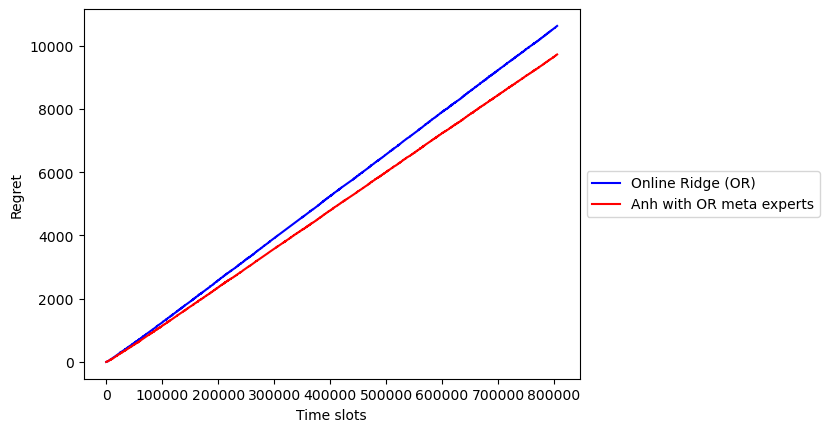

Group number 1, Tg is 763685 

    oridge end regret 8647.108101239637, Anh end regret 8428.489551443401, 

    Anh better Yes 
Oridge regret - Anh regret implementables 218.61854979623604
Relative difference percent 2.560596170546161


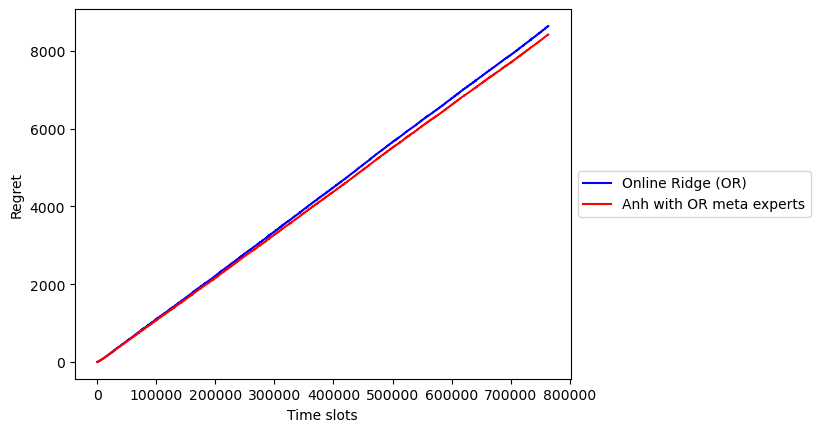

Group number 2, Tg is 1045807 

    oridge end regret 13259.661096390762, Anh end regret 12726.737973637977, 

    Anh better Yes 
Oridge regret - Anh regret implementables 532.9231227527853
Relative difference percent 4.10155421162164


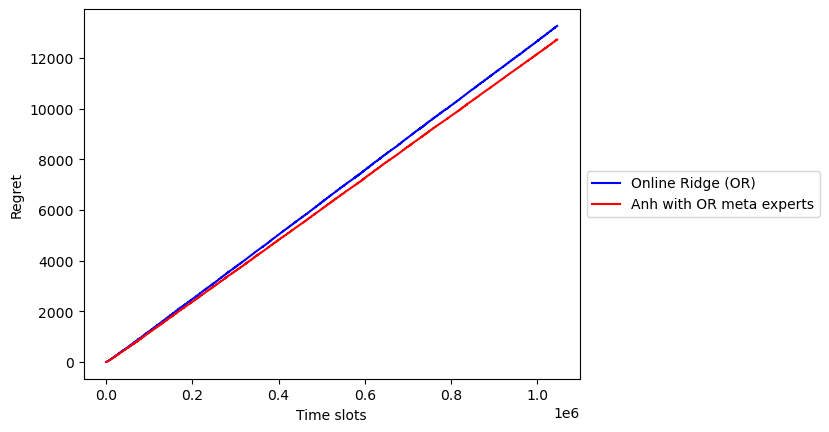

Group number 3, Tg is 136227 

    oridge end regret 1129.1009880805623, Anh end regret 1065.3286900701855, 

    Anh better Yes 
Oridge regret - Anh regret implementables 63.772298010376744
Relative difference percent 5.812197915963098


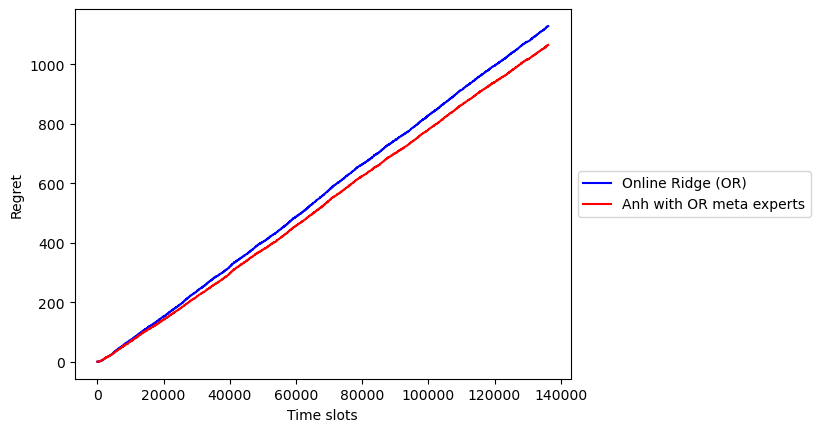

Group number 4, Tg is 14455 

    oridge end regret 87.27891717956834, Anh end regret 72.83888518129862, 

    Anh better Yes 
Oridge regret - Anh regret implementables 14.440031998269717
Relative difference percent 18.03676016702423


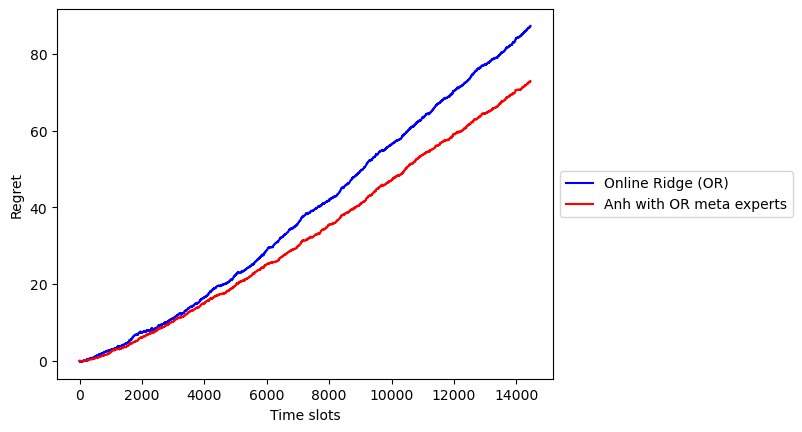

Group number 5, Tg is 726 

    oridge end regret 1.7140055746465883, Anh end regret 0.9387774502163779, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.7752281244302104
Relative difference percent 58.446402677072015


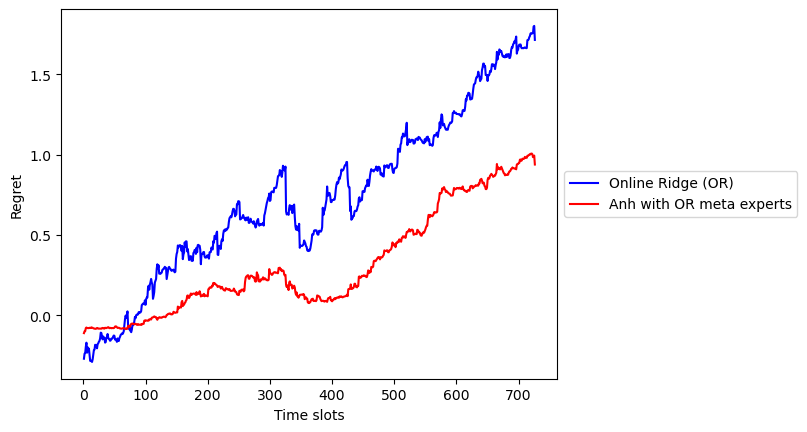

Group number 6, Tg is 2316 

    oridge end regret 13.626901536075259, Anh end regret 9.460585367230387, 

    Anh better Yes 
Oridge regret - Anh regret implementables 4.166316168844872
Relative difference percent 36.09155198479695


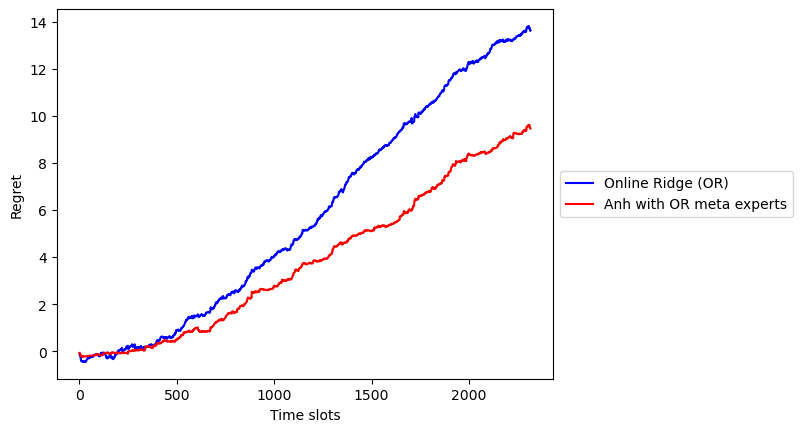

Group number 7, Tg is 100852 

    oridge end regret 2034.7731557524412, Anh end regret 1685.1914073123717, 

    Anh better Yes 
Oridge regret - Anh regret implementables 349.58174844006953
Relative difference percent 18.79489669934142


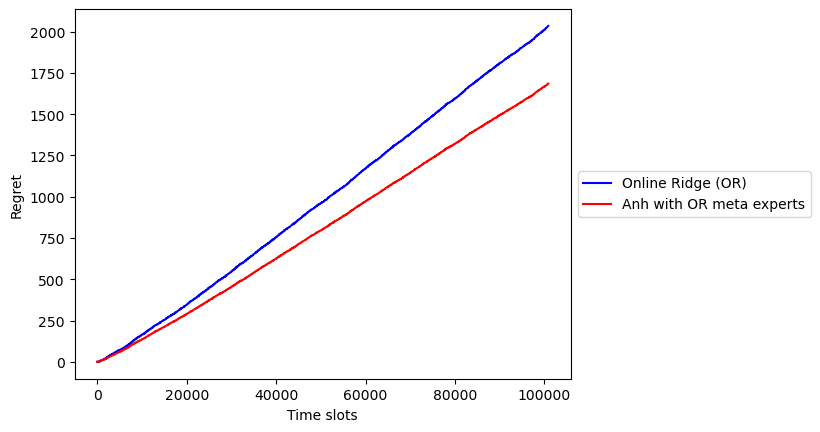

Group number 8, Tg is 2755 

    oridge end regret 12.198187294873833, Anh end regret 11.571512664134048, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.6266746307397852
Relative difference percent 5.272886336979593


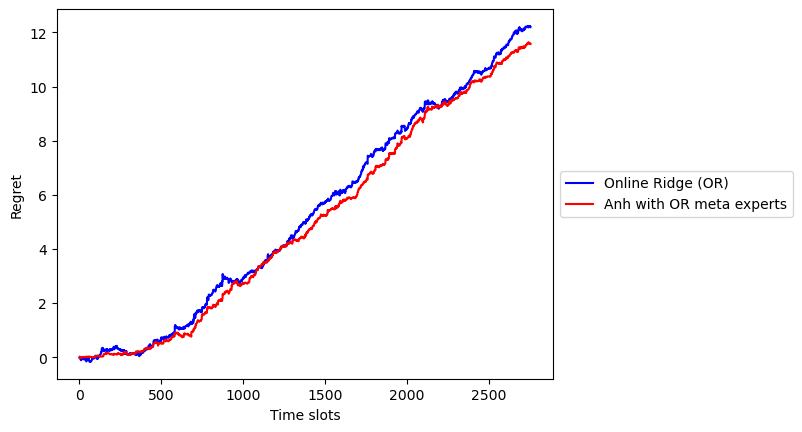

Group number 9, Tg is 97582 

    oridge end regret 729.8645206066778, Anh end regret 602.7561157278944, 

    Anh better Yes 
Oridge regret - Anh regret implementables 127.1084048787834
Relative difference percent 19.07645753234023


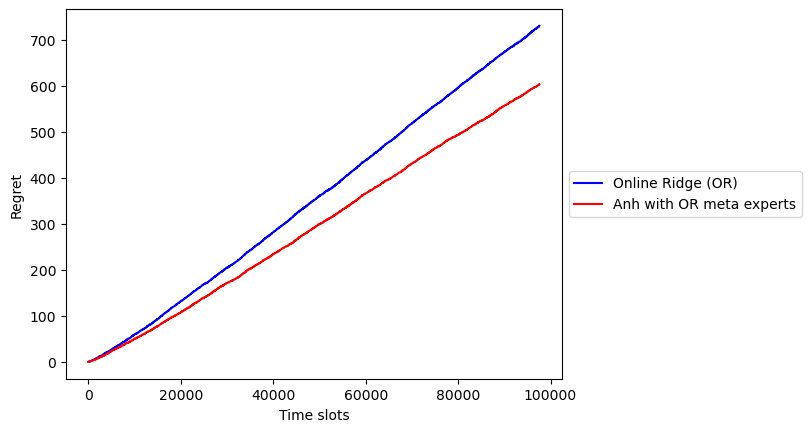

Group number 10, Tg is 168468 

    oridge end regret 1677.4828983287107, Anh end regret 1649.2467015612683, 

    Anh better Yes 
Oridge regret - Anh regret implementables 28.23619676744238
Relative difference percent 1.6975348262976468


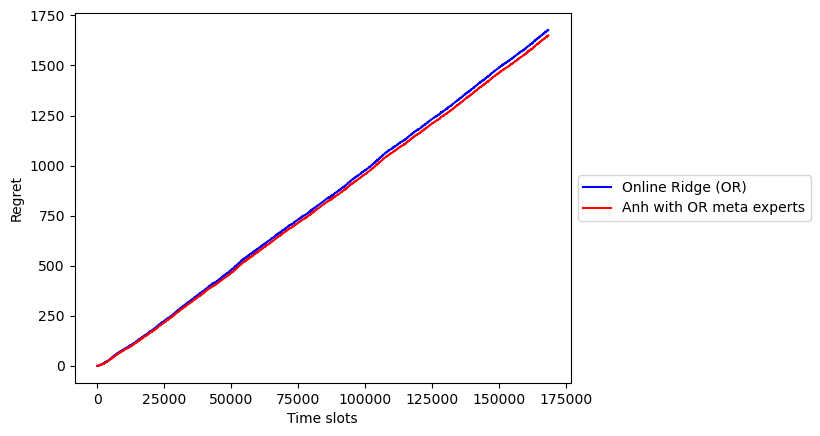

Group number 11, Tg is 1569188 

    oridge end regret 18849.463273598303, Anh end regret 17727.83325182512, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1121.6300217731841
Relative difference percent 6.132930141480434


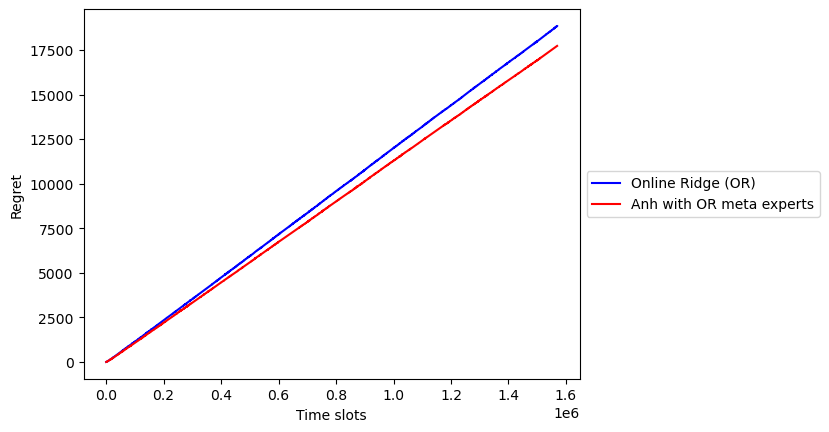

Anh better for 12 out of 12 groups


In [7]:
plot_ORidgevsAnh_together(di_sd_s42['oridge_implementable'].cumreg_groupwise_oridge, di_sd_s42['Anh'])

In [8]:
dir = './onehot_encoded/' # head directory for saving results
filename = 'allstate_shuffle_seed42_'
groups = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']

alm_obj = All_linear_models(dir, filename, data_fil, cat_cols_sig, groups)
di_sd_s42_drop = {}
di_sd_s42_drop['bls'] = 1
di_sd_s42_drop['Anh'] = 2
di_sd_s42_drop['oridge_implementable'] = 3
alm_obj.build_models(seed = 42, di_to_fill = di_sd_s42_drop, to_shuffle = True, to_drop_groups = True)

/Users/krisacha/Documents/multigroupcode/multigroup-code/build_all_models.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A_tdf['alwayson'] = 1 # adds the always active / using all data "group"
100%|██████████| 1569188/1569188 [13:57<00:00, 1873.97it/s]


Group number 0, Tg is 805503 

    oridge end regret 11438.879810131646, Anh end regret 9841.135458941964, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1597.7443511896818
Relative difference percent 15.016383503368012


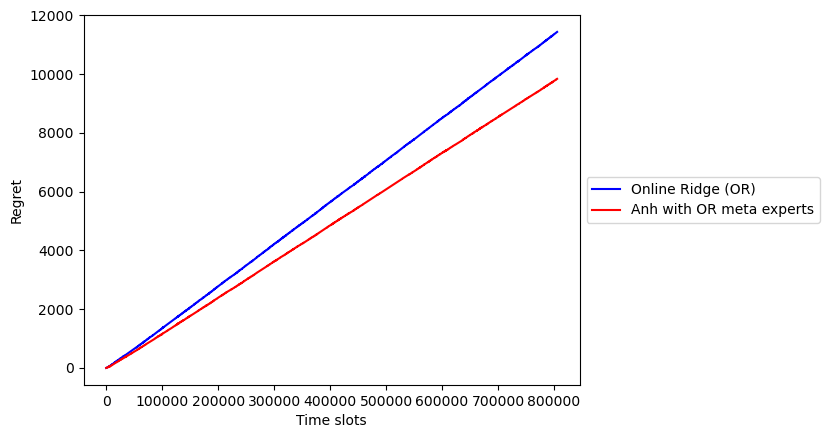

Group number 1, Tg is 763685 

    oridge end regret 9389.622281683378, Anh end regret 8526.94633420064, 

    Anh better Yes 
Oridge regret - Anh regret implementables 862.6759474827377
Relative difference percent 9.62992374240599


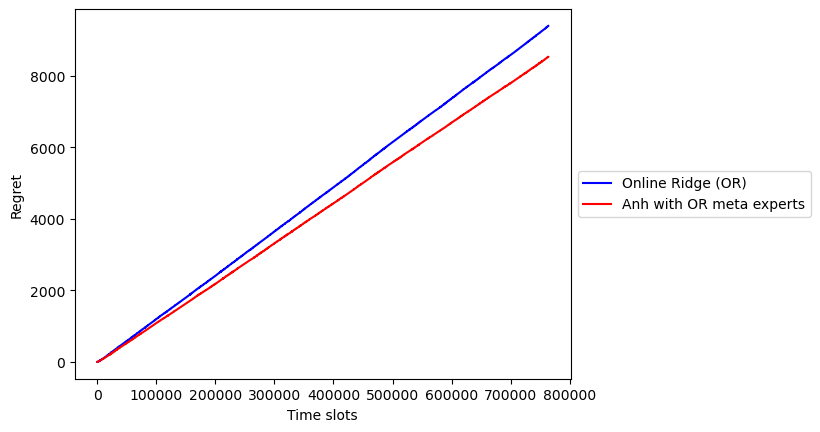

Group number 2, Tg is 1045807 

    oridge end regret 13841.218092155872, Anh end regret 12385.997721322408, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1455.2203708334637
Relative difference percent 11.097025175547758


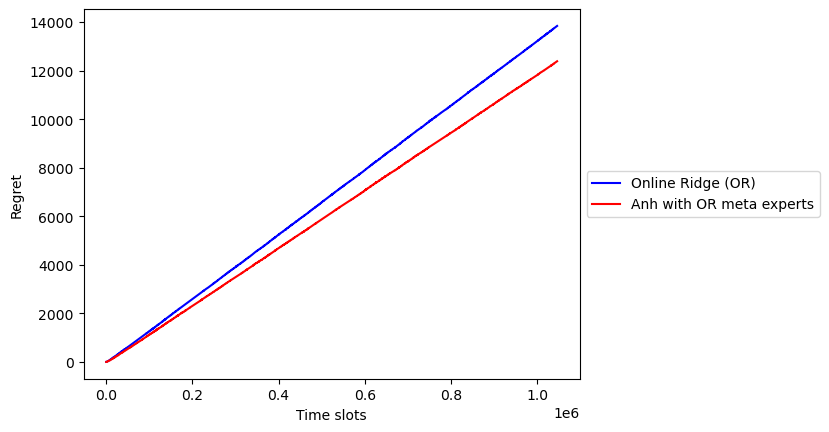

Group number 3, Tg is 136227 

    oridge end regret 1247.6008037334864, Anh end regret 1058.0074001142493, 

    Anh better Yes 
Oridge regret - Anh regret implementables 189.59340361923705
Relative difference percent 16.446281142028585


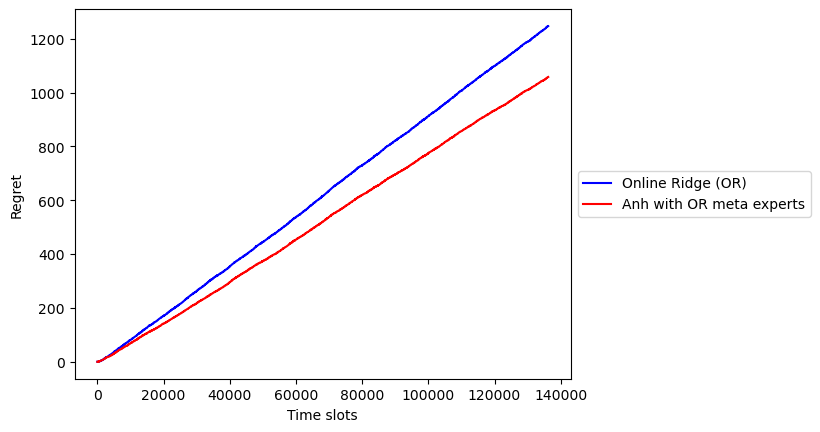

Group number 4, Tg is 14455 

    oridge end regret 98.54518214711658, Anh end regret 73.66755112440399, 

    Anh better Yes 
Oridge regret - Anh regret implementables 24.877631022712592
Relative difference percent 28.891744007673438


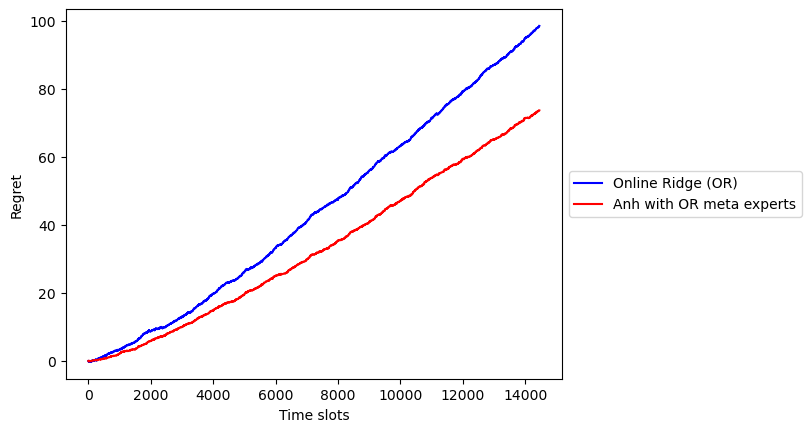

Group number 5, Tg is 726 

    oridge end regret 1.878184682284445, Anh end regret 0.8886763040897314, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.9895083781947136
Relative difference percent 71.52570245254074


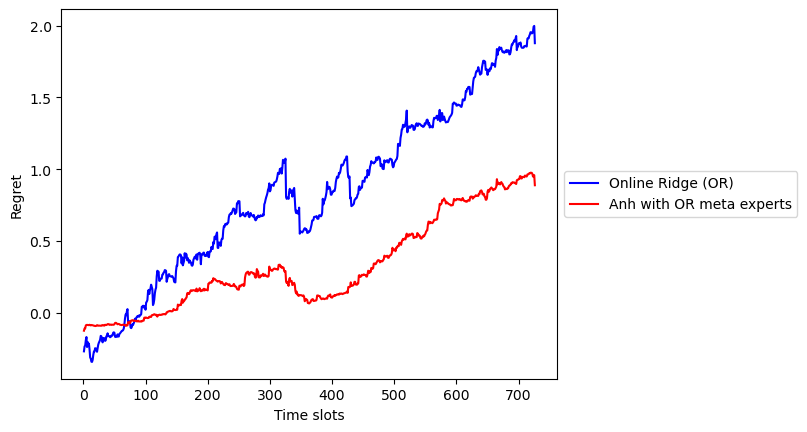

Group number 6, Tg is 2316 

    oridge end regret 14.559471762543595, Anh end regret 9.215988273087596, 

    Anh better Yes 
Oridge regret - Anh regret implementables 5.343483489455998
Relative difference percent 44.94956969453348


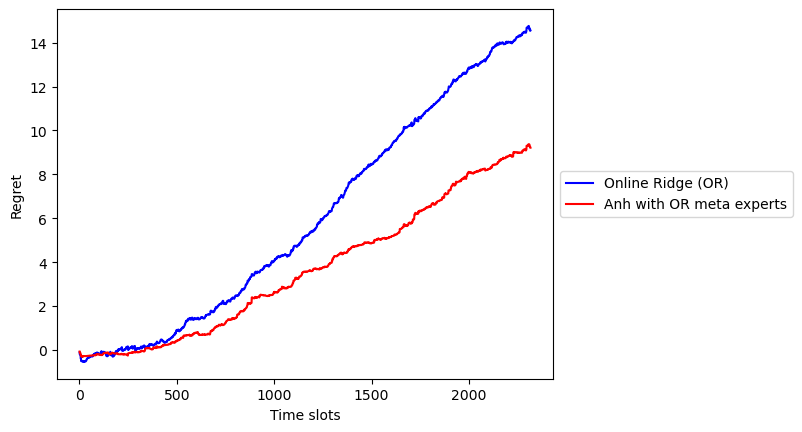

Group number 7, Tg is 100852 

    oridge end regret 2128.4747614792045, Anh end regret 1709.131652124203, 

    Anh better Yes 
Oridge regret - Anh regret implementables 419.3431093550016
Relative difference percent 21.854409450043104


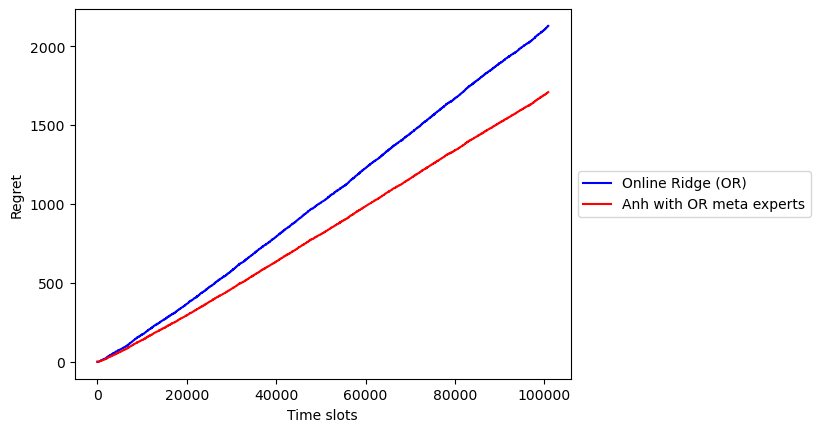

Group number 8, Tg is 2755 

    oridge end regret 13.390879616769197, Anh end regret 11.499156029238634, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1.8917235875305636
Relative difference percent 15.200649886043704


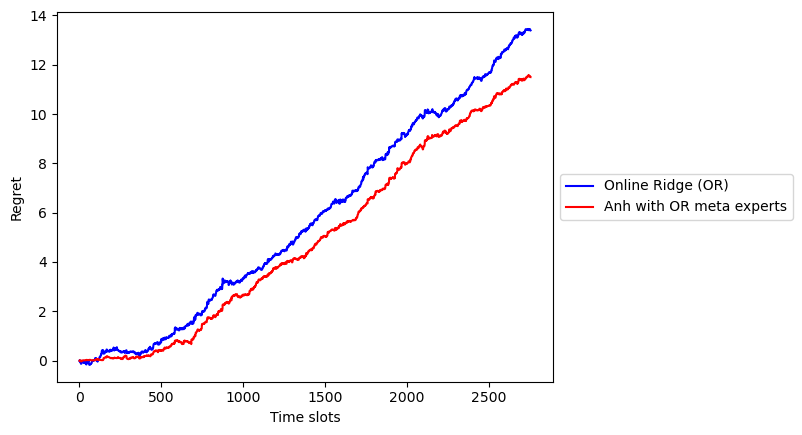

Group number 9, Tg is 97582 

    oridge end regret 844.1931704994013, Anh end regret 618.8647590966998, 

    Anh better Yes 
Oridge regret - Anh regret implementables 225.32841140270148
Relative difference percent 30.802390916251245


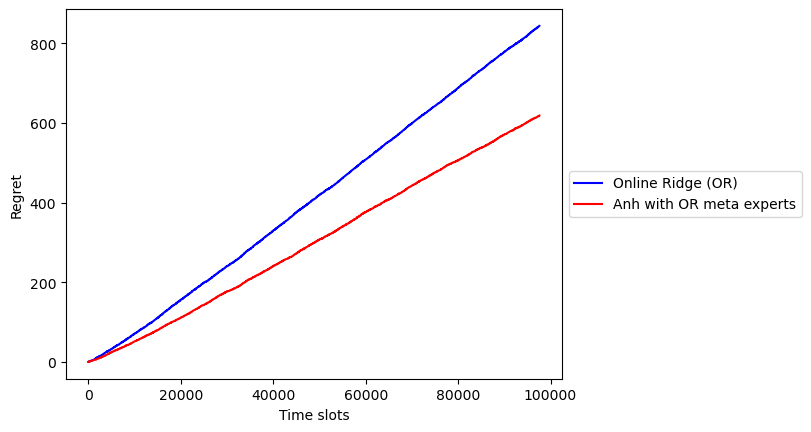

Group number 10, Tg is 168468 

    oridge end regret 1813.2308687527275, Anh end regret 1675.3982117675778, 

    Anh better Yes 
Oridge regret - Anh regret implementables 137.8326569851497
Relative difference percent 7.901823541790398


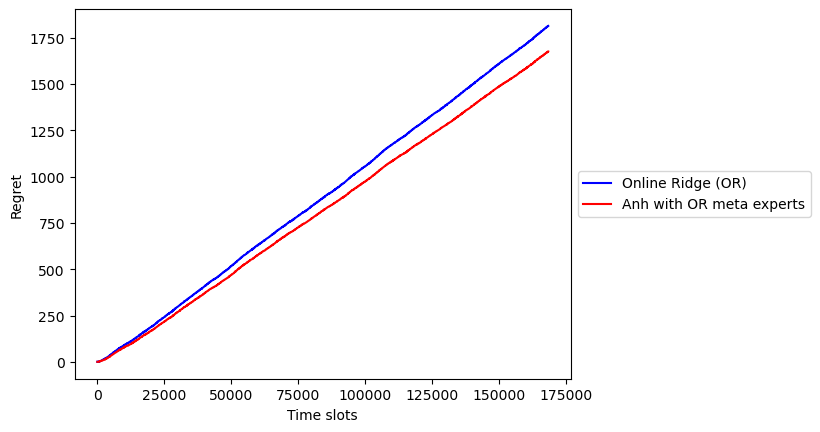

Group number 11, Tg is 1569188 

    oridge end regret 19895.29746715103, Anh end regret 17434.877168477113, 

    Anh better Yes 
Oridge regret - Anh regret implementables 2460.4202986739183
Relative difference percent 13.181938325708654


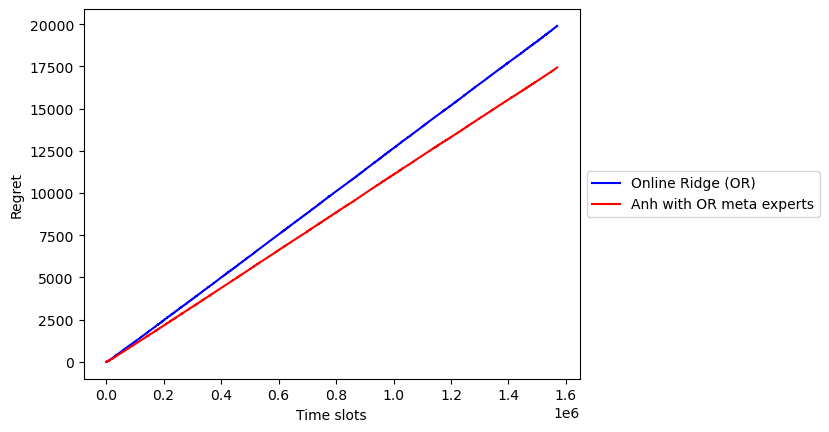

Anh better for 12 out of 12 groups


In [9]:
plot_ORidgevsAnh_together(di_sd_s42_drop['oridge_implementable'].cumreg_groupwise_oridge, di_sd_s42_drop['Anh'])